In [ ]:
'''import random
random.seed(42)
import numpy
numpy.random.seed(42)
from tensorflow import set_random_seed
set_random_seed(42)'''

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config
from spacy.lang.en import English
import spacy
spacy.prefer_gpu()
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Concatenate,GlobalMaxPool2D,Multiply
from tensorflow.keras.layers import Dropout, Subtract, Add, GlobalAvgPool2D, Conv2D, Bidirectional
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.initializers import glorot_uniform, Constant
from sklearn.model_selection import train_test_split
import os
import json
from src.PAN_evaluator import get_metrics
from src.DataGeneratorSiamese import DataGeneratorSiamese
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = 50):
    """
    t: tokenizer
    
    """
    not_present_list = []
    vocab_size = len(t.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
    for word, i in t.word_index.items():
        embedding_vector = None
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index.get(word)
        else:
            not_present_list.append(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.zeros(embedding_vector_size) # size of the embedding
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embedding_matrix

In [3]:
def exponent_neg_euclidean_distance(left, right):
    distance = tf.keras.backend.square(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    print("after sum, shape:", distance.shape)
    distance = tf.keras.backend.sqrt(distance)
    print("after sqrt, shape:", distance.shape)
    distance = -distance
    distance = tf.keras.backend.exp(distance)
    return distance

In [4]:
def exponent_neg_matusita_distance(left, right):
    left = tf.keras.backend.sqrt(left)
    right = tf.keras.backend.sqrt(right)
    distance = tf.keras.backend.square(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    distance = tf.keras.backend.sqrt(distance)
    distance = -distance
    distance = tf.keras.backend.exp(distance)
    return distance

In [5]:
def exponent_neg_cosine_distance(left,right):
    left = tf.keras.backend.l2_normalize(left, axis=-1)
    right = tf.keras.backend.l2_normalize(right, axis=-1)
    return tf.keras.backend.exp(tf.keras.backend.sum(tf.keras.backend.prod([left, right], axis=0), axis=1, keepdims=True))

In [6]:
def exponent_neg_manhattan_distance(left, right):
    distance = tf.keras.backend.abs(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    distance = -distance
    distance = tf.keras.backend.exp(distance)
    return distance

In [7]:
def create_model(max_len, embed_matrix, embedding_dim, tokenizer, distance_fn=exponent_neg_cosine_distance ):
    # this one works
    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))
    lstm_layer = Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1, 
                     embedding_dim, 
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len, 
                     weights=[embed_matrix],
                     trainable=True)
    e1 = emb(input_1)
    x1 = lstm_layer(e1)
    e2 = emb(input_2)
    x2 = lstm_layer(e2)
    mhd = lambda x: distance_fn(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='L1_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)
    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(clipnorm=1.5))
    print(model.summary())
    return model


In [8]:
def get_tokenizer(combined, max_words=10000):
    t = Tokenizer(num_words=max_words, oov_token="<OOV>")
    t.fit_on_texts(combined.values)
    return t

In [9]:
def get_embed_matrix(tokenizer, path = '/home/sukanya/PhD/Embeddings/Glove/glove.6B.50d.txt', embedding_dim = 50):
    embeddings_index = {}
    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    embed_matrix = get_glove_embed_matrix(tokenizer, embeddings_index, embedding_vector_size = embedding_dim)
    return embed_matrix

In [42]:
def evaluate(run_num, output_folder):
    max_len = 300
    embedding_dim = 50
    training_data = pd.read_csv(config.config_io.get('pan_21_processed_train'))
    combined = training_data["para1_text"] + " " + training_data["para2_text"]  
    tokenizer = get_tokenizer(combined, max_words=10000)
    embed_matrix = get_embed_matrix(tokenizer= tokenizer,
                                    path = '/home/sukanya/PhD/Embeddings/Glove/glove.6B.50d.txt', 
                                    embedding_dim = embedding_dim)
    len_train = len(training_data)
    training_generator = DataGeneratorSiamese(training_data.iloc[0:int(0.8*len_train)], 
                                              tokenizer=tokenizer,
                                              max_len=max_len,
                                              batch_size=64)
    validation_generator = DataGeneratorSiamese(training_data.iloc[int(0.8*len_train):], 
                                                tokenizer=tokenizer,
                                                max_len=max_len,
                                                batch_size=64)

    # this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
    training_generator.on_epoch_end()
    validation_generator.on_epoch_end()
    
    
    model = create_model(max_len=max_len,
                         embedding_dim=embedding_dim, 
                         embed_matrix=embed_matrix, 
                         tokenizer=tokenizer,
                         distance_fn=exponent_neg_cosine_distance )
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)#val_loss
    
    history = model.fit(training_generator, 
                        validation_data=validation_generator, 
                        verbose=1, 
                        batch_size=64, 
                        epochs=1, 
                        steps_per_epoch=2,
                        callbacks=[callback]) 
    # epochs=60, steps_per_epoch=100,
    train_loss = history.history['loss']
    train_acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    
    testing_data = pd.read_csv(config.config_io.get('pan_21_processed_test'))
    testing_generator = DataGeneratorSiamese(testing_data, 
                                             tokenizer=tokenizer, 
                                             max_len=max_len, 
                                             batch_size=64)
    testing_generator.on_epoch_end()
    test_loss, test_acc = model.evaluate(testing_generator)
    model_history_df = pd.DataFrame({"Training Accuracy": train_acc,
                                 "Validation Accuracy": val_acc,
                                 "Training loss": train_loss,
                                 "Validation Loss":val_loss})
    predictions_path = output_folder+"/"+str(run_num)+"/pan/"
    execute_PAN_test(model, predictions_path, tokenizer)
    task1_f1, task1_acc, task2_f1, task3_f1 = get_metrics(predictions_path =predictions_path,
                                                     truth_path = '/home/sukanya/PhD/CLEF/2021/validation/')

    metrics = {"Training Accuracy": train_acc[-1],
              "Validation Accuracy": val_acc[-1],
               "Testing Accuracy": test_acc,
               "Task1 Test F1 PAN": task1_f1,
               "Task1 Test Accuracy PAN": task1_acc,
               "Task2 Test F1 PAN":task2_f1,
               "Task3 Test F1 PAN":task3_f1}
    model_history_df.to_csv(output_folder+"/"+str(run_num)+"/model_history.csv", index=False)
    print(metrics)
    return metrics

In [12]:
def write_solution(problem_file, solutions_folder, sol_dict):
    if not os.path.exists(solutions_folder):
        os.makedirs(solutions_folder)
    solution_file = solutions_folder+"solution-"+problem_file.split(".")[0]+".json"    
    with open(solution_file, 'w+') as fp:
        json.dump(sol_dict, fp)#indent=4
        
data_path = config.config_io['pan_21_original_test']
print(data_path)
os.listdir(data_path)
base = [file.split(".")[0] for file in os.listdir(data_path) if "txt" in file]
truth_files = ["truth-"+file+".json" for file in base]
problem_files = [file+".txt" for file in base] 

/home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/validation/


In [34]:
def convertPAN_to_siamese_format_TIRA(problem_path, tokenizer):
    """
    No truth file should be accessible
    """
    with open(problem_path) as f:
        text = f.read()
    p1_list = []
    p2_list = []
    paragraphs = text.split("\n")
    non_zero_len_paragraphs = [para for para in paragraphs if len(para)>0] # problem-601 creates an empty paragraph causing the problem. so had to remove empty paragraphs
    for i in range(0, len(paragraphs)-1):
        p1_list.append(paragraphs[i])
        p2_list.append(paragraphs[i+1])
    df = pd.DataFrame({'para1_text':p1_list,
                      'para2_text':p2_list})
    p1_column = df['para1_text'].values
    p2_column = df['para2_text'].values
    p1_embed = tokenizer.texts_to_sequences(p1_column)
    p2_embed = tokenizer.texts_to_sequences(p2_column)
    max_len = len(paragraphs)-1
    p1_embed = pad_sequences(p1_embed, maxlen=max_len, padding='post')
    p2_embed = pad_sequences(p2_embed, maxlen=max_len, padding='post')
    return [p1_embed[i]], [p2_embed[i]] # WHAT IS THIS i?


In [14]:
def get_PAN_test_files(test_files_path=config.config_io['pan_21_original_test']):      
    print(test_files_path)
    base = [file.split(".")[0] for file in os.listdir(data_path) if "txt" in file]
    problem_files = [file+".txt" for file in base] 
    return problem_files

In [36]:
def execute_PAN_test(model, output_folder, tokenizer):
    test_files_path = config.config_io['pan_21_original_test']
    problem_files = get_PAN_test_files(test_files_path)
    for i in range(0, len(problem_files)):
        x = convertPAN_to_siamese_format_TIRA(test_files_path + problem_files[i], tokenizer)
        y_pred = model.predict(x, verbose=1)
        changes= np.argmax(y_pred, axis=-1).tolist()
        #changes = model.predict_classes(x, verbose=1).tolist()
        print(problem_files[i])
        multi_author = 0
        if sum(changes)>=1:
            multi_author = 1
        paragraph_authors =  [0]*(len(changes)+1)
        sol_dict = {"multi-author":multi_author, "changes":changes,
                    "paragraph-authors":paragraph_authors}
        print(sol_dict)
        write_solution(problem_files[i], output_folder, sol_dict)

In [41]:
train_acc_list = []
val_acc_list = []
task1_f1_list = []
task1_acc_list = [] #test set
task2_f2_list = []
task2_f3_list = []

for i in range(1,30):
    metrics = evaluate(1, "/home/sukanya/PhD/CLEF/2021/runs/run_30_apr_siamese_cosine/predicted/")
    

Found 400000 word vectors.
Loaded 400000 word vectors.
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 300, 50)      2795200     input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None

1/1 [==============================] - 0s 8ms/step
problem-1117.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-205.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-367.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2247.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2092.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1494.txt
{'multi-author': 0, 'changes': [0, 

1/1 [==============================] - 0s 9ms/step
problem-1029.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-81.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1144.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-1290.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-313.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-150.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2355.txt
{'multi-author

problem-1209.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-33.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-448.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1387.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-534.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-268.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-850.txt
{'multi-author': 0, 'changes': [0, 

1/1 [==============================] - 0s 9ms/step
problem-1345.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-746.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1501.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2146.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-60.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-226.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2109.txt


1/1 [==============================] - 0s 8ms/step
problem-1145.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-61.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1279.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1373.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-79.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2252.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1487.txt
{'multi-author': 0, 'cha

1/1 [==============================] - 0s 9ms/step
problem-63.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1896.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1948.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-272.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-737.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-674.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 

1/1 [==============================] - 0s 9ms/step
problem-312.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1561.txt
{'multi-author': 0, 'changes': [0], 'paragraph-authors': [0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-491.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1062.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2234.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-146.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==========================

1/1 [==============================] - 0s 8ms/step
problem-831.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1883.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1614.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1207.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-656.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1538.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [===================

1/1 [==============================] - 0s 9ms/step
problem-1891.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-118.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-489.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-372.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1405.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1810.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0,

1/1 [==============================] - 0s 9ms/step
problem-195.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-244.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1315.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1247.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2268.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1046.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [=

1/1 [==============================] - 0s 9ms/step
problem-765.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1794.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-530.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2295.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-783.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1967.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [=========================

1/1 [==============================] - 0s 9ms/step
problem-993.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2188.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1986.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-626.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-341.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-583.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-61

1/1 [==============================] - 0s 10ms/step
problem-600.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1771.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-638.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-124.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2320.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2129.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-author

problem-401.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-662.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-108.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2330.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2036.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-1708.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [===

1/1 [==============================] - 0s 9ms/step
problem-1174.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1450.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-556.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1250.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1741.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1639.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-728.txt
{'multi-author': 0, 'changes':

1/1 [==============================] - 0s 10ms/step
problem-1631.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1729.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-588.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2230.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1683.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2241.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0

1/1 [==============================] - 0s 9ms/step
problem-1398.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1194.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-872.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-3.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1624.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-704.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 

1/1 [==============================] - 0s 9ms/step
problem-139.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-949.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1357.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1765.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-589.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-816.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [======

1/1 [==============================] - 0s 10ms/step
problem-1143.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-153.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1722.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-294.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2351.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2255.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [======

1/1 [==============================] - 0s 9ms/step
problem-716.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-998.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-585.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-174.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-575.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1596.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================]

1/1 [==============================] - 0s 10ms/step
problem-2246.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-291.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-188.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-183.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1469.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1229.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0,

1/1 [==============================] - 0s 10ms/step
problem-1140.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
2/2 [==============================] - 0s 1ms/step
problem-1512.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1915.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-261.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1056.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 

1/1 [==============================] - 0s 10ms/step
problem-1382.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2141.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-492.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-806.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1648.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1572.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2133.txt
{'multi-autho

problem-1724.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1092.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-269.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1845.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1032.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1118.txt
{'multi-author': 0, 'changes': [0], 'paragraph-authors': [0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-218.txt
{'multi-author': 0, 'changes'

1/1 [==============================] - 0s 8ms/step
problem-611.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1734.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-348.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-521.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1258.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2238.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 

1/1 [==============================] - 0s 11ms/step
problem-1976.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-889.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1474.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-694.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-918.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-952.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-259.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 

1/1 [==============================] - 0s 10ms/step
problem-1542.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2049.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1884.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1242.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1920.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-2019.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-978.txt
{'mul

1/1 [==============================] - 0s 8ms/step
problem-437.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-733.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-1964.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-836.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1894.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1061.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1098.txt


1/1 [==============================] - 0s 10ms/step
problem-1975.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1019.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2361.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-451.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2175.txt
{'multi-author': 0, 'changes': [0], 'paragraph-authors': [0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-790.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-395.txt
{'multi-autho

1/1 [==============================] - 0s 10ms/step
problem-1563.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1350.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1903.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-985.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-969.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2197.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [=====

1/1 [==============================] - 0s 9ms/step
problem-948.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-2101.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-1982.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-2221.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1204.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-819.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
pro

1/1 [==============================] - 0s 10ms/step
problem-253.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1244.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2233.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1103.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2396.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1671.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/

1/1 [==============================] - 0s 9ms/step
problem-167.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1475.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1391.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-843.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-809.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-618.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-116.txt
{'multi-author': 0, 

1/1 [==============================] - 0s 11ms/step
problem-1956.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 11ms/step
problem-754.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-1675.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 10ms/step
problem-539.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1377.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2020.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1831.txt
{'multi-auth

1/1 [==============================] - 0s 10ms/step
problem-1911.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-483.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-625.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-989.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-888.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1590.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============

1/1 [==============================] - 0s 9ms/step
problem-1483.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1882.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-111.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-759.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2190.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1647.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1670.txt
{'multi-author':

1/1 [==============================] - 0s 9ms/step
problem-1010.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1945.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-761.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-398.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2262.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-369.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==========================

1/1 [==============================] - 0s 8ms/step
problem-655.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1423.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-37.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2314.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1762.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1656.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
prob

1/1 [==============================] - 0s 8ms/step
problem-97.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1691.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1181.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-245.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2335.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1170.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-27

1/1 [==============================] - 0s 8ms/step
problem-2274.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1620.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-171.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1106.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1228.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-208.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1095.txt
{'mu

1/1 [==============================] - 0s 8ms/step
problem-643.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-842.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1929.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-160.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2382.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1568.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============

1/1 [==============================] - 0s 8ms/step
problem-1218.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-2225.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-980.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-616.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1742.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1588.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2198.tx

1/1 [==============================] - 0s 9ms/step
problem-289.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-83.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1155.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2328.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1200.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-22.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [======================

1/1 [==============================] - 0s 8ms/step
problem-1526.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2394.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1506.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-912.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1508.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 13ms/step
problem-646.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 

1/1 [==============================] - 0s 9ms/step
problem-897.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-112.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1214.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1365.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2067.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1153.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1

1/1 [==============================] - 0s 9ms/step
problem-2118.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-5.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1941.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-467.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1468.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-1709.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors'

1/1 [==============================] - 0s 10ms/step
problem-672.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1607.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-2108.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-617.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 9ms/step
problem-1067.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [==============================] - 0s 8ms/step
problem-586.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
1/1 [=

/home/sukanya/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [43]:
metrics

{'Training Accuracy': 0.4609375,
 'Validation Accuracy': 0.5345873832702637,
 'Task1 Test F1 PAN': 0.2,
 'Task1 Test Accuracy PAN': 0.25,
 'Task2 Test F1 PAN': 0.3172681036570598,
 'Task3 Test F1 PAN': 0.0}

In [16]:
'''def exponent_neg_manhattan_distance(left, right):
    # Helper function for the similarity estimate of the LSTMs outputs
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
'''

'def exponent_neg_manhattan_distance(left, right):\n    # Helper function for the similarity estimate of the LSTMs outputs\n    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))\n'

In [16]:
print("Loading training file from path: ", config.config_io.get('pan_21_processed_train'))
training_data = pd.read_csv(config.config_io.get('pan_21_processed_train'))
training_data.head()

Loading training file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/processed/train.csv


,problem,author_1,author_2,para1_text,para2_text
0,problem-4845.txt,1,2,I can't see the names (as you've properly reda...,Does it have anything to do that in this parti...
1,problem-4845.txt,2,2,Does it have anything to do that in this parti...,I am having a problem with connectivity in one...
2,problem-4845.txt,2,1,I am having a problem with connectivity in one...,Aliases are a way for the client to be redirec...
3,problem-4845.txt,1,1,Aliases are a way for the client to be redirec...,It doesn't deal with any of that. It specifica...
4,problem-9721.txt,1,2,"There is no non-root command, but a root comma...","For my situation, the use of locking is not su..."


In [17]:
combined = training_data["para1_text"] + " " + training_data["para2_text"]

In [18]:
max_words = 10000
t = Tokenizer(num_words=max_words, oov_token="<OOV>")
t.fit_on_texts(combined.values)


In [19]:
max_len = 300

We see that most of the values are less than say len 100, so we can infact try with length 200 and see how that goes

In [20]:
embeddings_index = {}
f = open('/home/sukanya/PhD/Embeddings/Glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_dim = 50
embed_matrix = get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = embedding_dim)

Loaded 400000 word vectors.


In [22]:
embed_matrix.shape

(55904, 50)

In [23]:
from src.DataGeneratorSiamese import DataGeneratorSiamese
len_train = len(training_data)
#
#
training_generator = DataGeneratorSiamese(training_data.iloc[0:int(0.8*len_train)], tokenizer=t,max_len=max_len, batch_size=64)
validation_generator = DataGeneratorSiamese(training_data.iloc[int(0.8*len_train):], tokenizer=t, max_len=max_len, batch_size=64)

# this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
training_generator.on_epoch_end()
validation_generator.on_epoch_end()

In [24]:
# this one works
input_1 = Input(shape=(max_len,))#(train_p1_seq.shape[1],)
input_2 = Input(shape=(max_len,))


lstm_layer = Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
#lstm_layer = tf.keras.layers.LSTM(50, name="common_lstm_layer")
# max_words 10000 , embedding_dim = 50, max_len = 300
embeddings_initializer = Constant(embed_matrix)
emb =  Embedding(len(t.word_index)+1, 
                 embedding_dim, 
                 embeddings_initializer=embeddings_initializer,
                 input_length=max_len, 
                 weights=[embed_matrix],
                 trainable=True)

e1 = emb(input_1)
x1 = lstm_layer(e1)

e2 = emb(input_2)
x2 = lstm_layer(e2)


mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) #manh_lstm_distance 
merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='L1_distance')([x1, x2])
preds = Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_1, input_2], outputs=preds)
model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(clipnorm=1.5))


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 50)      2795200     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100)          40400       embedding[0][0]              

In [26]:
#model = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)#val_loss
history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=64, 
                             epochs=60, steps_per_epoch=100, callbacks=[callback]) #, 

Epoch 1/60
100/100 [==============================] - 42s 377ms/step - loss: 1.3696 - acc: 0.4514 - val_loss: 1.0292 - val_acc: 0.4654
Epoch 2/60
100/100 [==============================] - 38s 377ms/step - loss: 0.9987 - acc: 0.4628 - val_loss: 0.9498 - val_acc: 0.4654
Epoch 3/60
100/100 [==============================] - 38s 377ms/step - loss: 0.8970 - acc: 0.4870 - val_loss: 0.8980 - val_acc: 0.4654
Epoch 4/60
100/100 [==============================] - 38s 376ms/step - loss: 0.8760 - acc: 0.4651 - val_loss: 0.8543 - val_acc: 0.4654
Epoch 5/60
100/100 [==============================] - 40s 402ms/step - loss: 0.8322 - acc: 0.4651 - val_loss: 0.8062 - val_acc: 0.4654
Epoch 6/60
100/100 [==============================] - 40s 398ms/step - loss: 0.7871 - acc: 0.4604 - val_loss: 0.7709 - val_acc: 0.4654
Epoch 7/60
100/100 [==============================] - 40s 396ms/step - loss: 0.7730 - acc: 0.4449 - val_loss: 0.7429 - val_acc: 0.4683
Epoch 8/60
100/100 [==============================] - 4

In [27]:
testing_data = pd.read_csv(config.config_io.get('pan_21_processed_test'))
testing_generator = DataGeneratorSiamese(testing_data, tokenizer=t, max_len=max_len, batch_size=64)
testing_generator.on_epoch_end()

In [28]:
test_loss, test_acc = model.evaluate(testing_generator)

220/220 [==============================] - 10s 44ms/step - loss: 0.6307 - acc: 0.6429


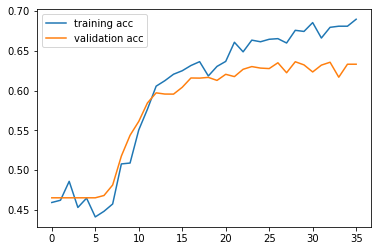

In [29]:
acc = pd.DataFrame({"training acc":history.history['acc'], 
                            "validation acc": history.history['val_acc']})
acc.plot()

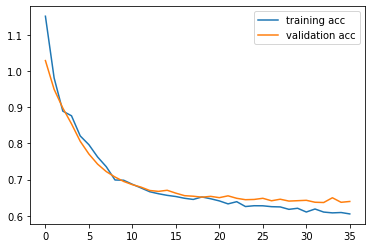

In [30]:
loss = pd.DataFrame({"training acc":history.history['loss'], 
                            "validation acc": history.history['val_loss']})
loss.plot()

In [59]:
test_loss, test_acc = model.evaluate(testing_generator)

220/220 [==============================] - 17s 79ms/step - loss: 0.6433 - acc: 0.6379


In [1]:
from src.PAN_evaluator import get_metrics

task1_f1, task1_acc, task2_f1, task3_f1 = get_metrics(predictions_path ='/home/sukanya/PhD/CLEF/2021/runs/run_29_apr_1',
                                                     truth_path = '/home/sukanya/PhD/CLEF/2021/validation/')

truth confusion matrix
[[ 600    0]
 [   0 1800]]
prediction confusion matrix
prediction accuracy 0.7704166666666666
[[ 157  443]
 [ 108 1692]]
14095 14095
14095 14095
16495 16495
16495 16495


/home/sukanya/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [2]:
task1_f1, task1_acc, task2_f1, task3_f1

(0.6114901836931054, 0.7704166666666666, 0.5176433321878919, 0.0)

In [31]:
solutions_folder = "/home/sukanya/PhD/CLEF/2021/runs/run_28_apr_siamese_cosine/predicted"
for i in range(0, len(problem_files)): #len(problem_files)
    testing_data_df = convertPAN_to_siamese_format(data_path + problem_files[i],data_path + truth_files[i], problem_files[i])
    DataGeneratorSiamese(testing_data_df, tokenizer=t, max_len=max_len, batch_size=64)
    testing_generator = DataGeneratorSiamese(testing_data_df, tokenizer=t,  max_len=max_len, 
                                             batch_size=len(testing_data_df))
    testing_generator.on_epoch_end()
    print(model.evaluate(testing_generator))
    y_pred = model.predict(testing_generator, verbose=1)
    #print("y pred", y_pred)
    print("arg max",  np.where(y_pred > 0.5, 1, 0).flatten().tolist())
    changes= np.argmax(y_pred, axis=-1).tolist()#np.where(y_pred > 0.5, 1, 0).flatten().tolist()
    print(problem_files[i])
    multi_author = 0
    if sum(changes)>=1:
        multi_author = 1
    paragraph_authors =  [0]*(len(changes)+1)
    sol_dict = {"multi-author":multi_author, "changes":changes,
                "paragraph-authors":paragraph_authors}
    print(sol_dict)
    write_solution(problem_files[i], solutions_folder, sol_dict)

len: 1046
1/1 [==============================] - 0s 58ms/step - loss: 0.7949 - acc: 0.5000
[0.7948583960533142, 0.5]
1/1 [==============================] - 0s 447ms/step
y pred [[0.36449355]
 [0.6790223 ]]
arg max [0, 1]
problem-1543.txt
{'multi-author': 1, 'changes': [0, 1], 'paragraph-authors': [0, 0, 0]}
len: 1887
1/1 [==============================] - 0s 60ms/step - loss: 0.5501 - acc: 0.7500
[0.5501011610031128, 0.75]
1/1 [==============================] - 0s 55ms/step
y pred [[0.6644995 ]
 [0.44678977]
 [0.6591916 ]
 [0.67190576]
 [0.64145577]
 [0.40006503]
 [0.6153302 ]
 [0.522864  ]]
arg max [1, 0, 1, 1, 1, 0, 1, 1]
problem-631.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1142
1/1 [==============================] - 0s 56ms/step - loss: 0.7169 - acc: 0.6667
[0.7168977856636047, 0.6666666865348816]
1/1 [==============================] - 0s 59ms/step
y pred [[0.6763784 ]
 [0.36668435]
 [0.6075835 ]
 [0.59641963

1/1 [==============================] - 0s 57ms/step - loss: 0.6516 - acc: 0.6667
[0.6515621542930603, 0.6666666865348816]
1/1 [==============================] - 0s 57ms/step
y pred [[0.36409163]
 [0.6443891 ]
 [0.5514854 ]
 [0.66583997]
 [0.67982626]
 [0.37956926]]
arg max [0, 1, 1, 1, 1, 0]
problem-2281.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1498
1/1 [==============================] - 0s 59ms/step - loss: 0.6555 - acc: 0.5000
[0.6555349230766296, 0.5]
1/1 [==============================] - 0s 58ms/step
y pred [[0.678249  ]
 [0.48272836]
 [0.39831293]
 [0.59497535]
 [0.6233984 ]
 [0.67008746]]
arg max [1, 0, 0, 1, 1, 1]
problem-2167.txt
{'multi-author': 1, 'changes': [1, 0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 2044
1/1 [==============================] - 0s 58ms/step - loss: 0.6057 - acc: 0.6250
[0.6057298183441162, 0.625]
1/1 [==============================] - 0s 59ms/step
y pred [[0.32362133]
 [0

1/1 [==============================] - 0s 56ms/step - loss: 0.8192 - acc: 0.5000
[0.8191697597503662, 0.5]
1/1 [==============================] - 0s 58ms/step
y pred [[0.48437414]
 [0.59301364]
 [0.49328163]
 [0.6449617 ]]
arg max [0, 1, 0, 1]
problem-329.txt
{'multi-author': 1, 'changes': [0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1072
1/1 [==============================] - 0s 54ms/step - loss: 0.7300 - acc: 0.5000
[0.7300187945365906, 0.5]
1/1 [==============================] - 0s 55ms/step
y pred [[0.59396833]
 [0.42805558]]
arg max [1, 0]
problem-518.txt
{'multi-author': 1, 'changes': [1, 0], 'paragraph-authors': [0, 0, 0]}
len: 2352
1/1 [==============================] - 0s 58ms/step - loss: 0.4657 - acc: 0.8889
[0.4657423794269562, 0.8888888955116272]
1/1 [==============================] - 0s 59ms/step
y pred [[0.32653522]
 [0.31364805]
 [0.3055817 ]
 [0.3076968 ]
 [0.31633514]
 [0.31971338]
 [0.68429255]
 [0.6841906 ]
 [0.6770091 ]]
arg max [0, 0, 0, 0, 0, 0, 1, 1,

[0.5151976943016052, 1.0]
1/1 [==============================] - 0s 60ms/step
y pred [[0.45701867]
 [0.66560155]
 [0.5898726 ]]
arg max [0, 1, 1]
problem-1144.txt
{'multi-author': 1, 'changes': [0, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 2096
1/1 [==============================] - 0s 60ms/step - loss: 0.4442 - acc: 1.0000
[0.44416365027427673, 1.0]
1/1 [==============================] - 0s 56ms/step
y pred [[0.60358447]
 [0.59296155]
 [0.6302006 ]
 [0.33005014]
 [0.6608495 ]
 [0.30301297]]
arg max [1, 1, 1, 0, 1, 0]
problem-1290.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1114
1/1 [==============================] - 0s 54ms/step - loss: 0.8082 - acc: 0.3333
[0.8081612586975098, 0.3333333432674408]
1/1 [==============================] - 0s 56ms/step
y pred [[0.4374344 ]
 [0.66305655]
 [0.3052084 ]]
arg max [0, 1, 0]
problem-313.txt
{'multi-author': 1, 'changes': [0, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 1666
1/1 

1/1 [==============================] - 0s 55ms/step - loss: 0.4011 - acc: 1.0000
[0.4010735750198364, 1.0]
1/1 [==============================] - 0s 61ms/step
y pred [[0.681419  ]
 [0.33631712]
 [0.3416173 ]
 [0.66386014]
 [0.6581566 ]
 [0.64766455]
 [0.31653816]
 [0.30882123]
 [0.67987615]]
arg max [1, 0, 0, 1, 1, 1, 0, 0, 1]
problem-778.txt
{'multi-author': 1, 'changes': [1, 0, 0, 1, 1, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1108
1/1 [==============================] - 0s 56ms/step - loss: 1.1280 - acc: 0.0000e+00
[1.1279797554016113, 0.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.67631346]]
arg max [1]
problem-2336.txt
{'multi-author': 1, 'changes': [1], 'paragraph-authors': [0, 0]}
len: 1131
1/1 [==============================] - 0s 57ms/step - loss: 0.5523 - acc: 1.0000
[0.5523332357406616, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.42207786]
 [0.4115263 ]
 [0.45311686]
 [0.35449162]
 [0.47370315]]
arg ma

1/1 [==============================] - 0s 59ms/step - loss: 0.6508 - acc: 0.7500
[0.6507858037948608, 0.75]
1/1 [==============================] - 0s 56ms/step
y pred [[0.6808299 ]
 [0.6795307 ]
 [0.30690286]
 [0.52145976]]
arg max [1, 1, 0, 1]
problem-1516.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1007
1/1 [==============================] - 0s 58ms/step - loss: 0.5881 - acc: 1.0000
[0.58809894323349, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.5007085 ]
 [0.4232713 ]
 [0.58318305]
 [0.56494486]]
arg max [1, 0, 1, 1]
problem-1336.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1292
1/1 [==============================] - 0s 58ms/step - loss: 0.7243 - acc: 0.3333
[0.724257230758667, 0.3333333432674408]
1/1 [==============================] - 0s 56ms/step
y pred [[0.5150826]
 [0.5375737]
 [0.478033 ]]
arg max [1, 1, 0]
problem-1078.txt
{'multi-author': 1, 'changes': [1, 1, 

1/1 [==============================] - 0s 57ms/step
y pred [[0.30218276]
 [0.30172926]
 [0.3062356 ]
 [0.31799865]
 [0.3199352 ]
 [0.5417685 ]]
arg max [0, 0, 0, 0, 0, 1]
problem-1995.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 2413
1/1 [==============================] - 0s 55ms/step - loss: 0.7180 - acc: 0.4286
[0.7180353999137878, 0.4285714328289032]
1/1 [==============================] - 0s 61ms/step
y pred [[0.56747794]
 [0.4938737 ]
 [0.6816504 ]
 [0.6698106 ]
 [0.67573726]
 [0.6848162 ]
 [0.34153998]]
arg max [1, 0, 1, 1, 1, 1, 0]
problem-1832.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 2255
1/1 [==============================] - 0s 58ms/step - loss: 0.5855 - acc: 0.6667
[0.5854580998420715, 0.6666666865348816]
1/1 [==============================] - 0s 62ms/step
y pred [[0.31833297]
 [0.37461144]
 [0.6751484 ]
 [0.5970607 ]
 [0.4962991 ]
 [0.640166  ]
 [0.

1/1 [==============================] - 0s 57ms/step - loss: 0.7683 - acc: 0.1667
[0.7682927250862122, 0.1666666716337204]
1/1 [==============================] - 0s 60ms/step
y pred [[0.5696201 ]
 [0.44645563]
 [0.5004292 ]
 [0.5158946 ]
 [0.641152  ]
 [0.5185443 ]]
arg max [1, 0, 1, 1, 1, 1]
problem-60.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1114
1/1 [==============================] - 0s 54ms/step - loss: 0.7013 - acc: 0.5000
[0.7013423442840576, 0.5]
1/1 [==============================] - 0s 55ms/step
y pred [[0.64388925]
 [0.6466546 ]
 [0.30775568]
 [0.30561617]]
arg max [1, 1, 0, 0]
problem-226.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1935
1/1 [==============================] - 0s 59ms/step - loss: 0.6425 - acc: 0.6667
[0.6424841284751892, 0.6666666865348816]
1/1 [==============================] - 0s 57ms/step
y pred [[0.31218147]
 [0.366535  ]
 [0.3625967 ]
 [0.3010186

1/1 [==============================] - 0s 58ms/step - loss: 0.7138 - acc: 0.5000
[0.7138426303863525, 0.5]
1/1 [==============================] - 0s 56ms/step
y pred [[0.36219037]
 [0.6675435 ]
 [0.5439617 ]
 [0.4050217 ]]
arg max [0, 1, 1, 0]
problem-2254.txt
{'multi-author': 1, 'changes': [0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1591
1/1 [==============================] - 0s 57ms/step - loss: 0.3914 - acc: 1.0000
[0.3914381265640259, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.66852957]
 [0.36631173]
 [0.6844249 ]
 [0.30433413]
 [0.3084618 ]
 [0.6846436 ]]
arg max [1, 0, 1, 0, 0, 1]
problem-59.txt
{'multi-author': 1, 'changes': [1, 0, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1077
1/1 [==============================] - 0s 54ms/step - loss: 0.4114 - acc: 1.0000
[0.4114292562007904, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.6706156 ]
 [0.68446726]
 [0.36594152]]
arg max [1, 1, 0]
problem-132.txt
{'mul

1/1 [==============================] - 0s 59ms/step - loss: 0.7591 - acc: 0.4000
[0.759140133857727, 0.4000000059604645]
1/1 [==============================] - 0s 59ms/step
y pred [[0.627731  ]
 [0.55024964]
 [0.41674912]
 [0.67329264]
 [0.65508056]
 [0.5063878 ]
 [0.37501168]
 [0.41322044]
 [0.38861227]
 [0.46214125]]
arg max [1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
problem-209.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 1, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1030
1/1 [==============================] - 0s 55ms/step - loss: 0.4024 - acc: 1.0000
[0.4024408459663391, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.37275058]
 [0.34196514]
 [0.30459923]
 [0.30343083]]
arg max [0, 0, 0, 0]
problem-516.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1691
1/1 [==============================] - 0s 58ms/step - loss: 0.7065 - acc: 0.6667
[0.7065362930297852, 0.6666666865348816]
1/1 [===============

1/1 [==============================] - 0s 55ms/step - loss: 0.7626 - acc: 0.4000
[0.7626180648803711, 0.4000000059604645]
1/1 [==============================] - 0s 56ms/step
y pred [[0.6830827 ]
 [0.51384515]
 [0.6479391 ]
 [0.31523585]
 [0.32552034]]
arg max [1, 1, 1, 0, 0]
problem-386.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1687
1/1 [==============================] - 0s 57ms/step - loss: 0.8369 - acc: 0.3333
[0.8368809223175049, 0.3333333432674408]
1/1 [==============================] - 0s 55ms/step
y pred [[0.52338636]
 [0.59945065]
 [0.64310366]
 [0.678897  ]
 [0.43718463]
 [0.4643161 ]]
arg max [1, 1, 1, 1, 0, 0]
problem-2098.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1289
1/1 [==============================] - 0s 54ms/step - loss: 0.4239 - acc: 1.0000
[0.42385411262512207, 1.0]
1/1 [==============================] - 0s 59ms/step
y pred [[0.31946364]
 [0.37050304]

1/1 [==============================] - 0s 56ms/step - loss: 0.5168 - acc: 1.0000
[0.516770601272583, 1.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.634847 ]
 [0.5947674]
 [0.5619426]]
arg max [1, 1, 1]
problem-665.txt
{'multi-author': 1, 'changes': [1, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 1740
1/1 [==============================] - 0s 57ms/step - loss: 0.7243 - acc: 0.3333
[0.7242845892906189, 0.3333333432674408]
1/1 [==============================] - 0s 54ms/step
y pred [[0.5211218 ]
 [0.49025586]
 [0.3991951 ]
 [0.33045688]
 [0.43856436]
 [0.6320644 ]]
arg max [1, 0, 0, 0, 0, 1]
problem-1838.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 6839
1/1 [==============================] - 0s 62ms/step - loss: 0.5814 - acc: 0.7222
[0.5813586711883545, 0.7222222089767456]
1/1 [==============================] - 0s 59ms/step
y pred [[0.60010195]
 [0.678593  ]
 [0.6613594 ]
 [0.61854714]
 [0.55270314]
 [0.3065

1/1 [==============================] - 0s 58ms/step - loss: 0.5864 - acc: 0.8000
[0.5863760709762573, 0.800000011920929]
1/1 [==============================] - 0s 57ms/step
y pred [[0.59580636]
 [0.6154855 ]
 [0.40611634]
 [0.3561294 ]
 [0.608391  ]]
arg max [1, 1, 0, 0, 1]
problem-351.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1455
1/1 [==============================] - 0s 57ms/step - loss: 0.4935 - acc: 0.6667
[0.49346742033958435, 0.6666666865348816]
1/1 [==============================] - 0s 55ms/step
y pred [[0.5215014 ]
 [0.68027717]
 [0.30095854]]
arg max [1, 1, 0]
problem-945.txt
{'multi-author': 1, 'changes': [1, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 1356
1/1 [==============================] - 0s 55ms/step - loss: 0.6248 - acc: 0.8333
[0.6247746348381042, 0.8333333134651184]
1/1 [==============================] - 0s 58ms/step
y pred [[0.65567577]
 [0.3831411 ]
 [0.37761858]
 [0.43896073]
 [0.5317398 ]
 [0.48315275]

1/1 [==============================] - 0s 58ms/step
y pred [[0.6766262]
 [0.6659518]
 [0.6566003]
 [0.4939985]
 [0.4120127]]
arg max [1, 1, 1, 0, 0]
problem-494.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 2309
1/1 [==============================] - 0s 56ms/step - loss: 0.6154 - acc: 0.6667
[0.6154484152793884, 0.6666666865348816]
1/1 [==============================] - 0s 56ms/step
y pred [[0.66524976]
 [0.67117804]
 [0.6754247 ]
 [0.68077904]
 [0.45799708]
 [0.4447763 ]]
arg max [1, 1, 1, 1, 0, 0]
problem-663.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1060
1/1 [==============================] - 0s 59ms/step - loss: 0.5405 - acc: 1.0000
[0.5405375957489014, 1.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.5122234]
 [0.6622707]]
arg max [1, 1]
problem-1801.txt
{'multi-author': 1, 'changes': [1, 1], 'paragraph-authors': [0, 0, 0]}
len: 1696
1/1 [===========

1/1 [==============================] - 0s 56ms/step - loss: 0.6153 - acc: 0.7500
[0.6152824759483337, 0.75]
1/1 [==============================] - 0s 57ms/step
y pred [[0.65413034]
 [0.4842985 ]
 [0.6804347 ]
 [0.37178826]]
arg max [1, 0, 1, 0]
problem-656.txt
{'multi-author': 1, 'changes': [1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1713
1/1 [==============================] - 0s 58ms/step - loss: 0.7293 - acc: 0.4000
[0.7293320894241333, 0.4000000059604645]
1/1 [==============================] - 0s 61ms/step
y pred [[0.44057736]
 [0.43090388]
 [0.3909756 ]
 [0.40138367]
 [0.6337444 ]
 [0.5940826 ]
 [0.63932383]
 [0.5618452 ]
 [0.6133143 ]
 [0.63883984]]
arg max [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
problem-1538.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1299
1/1 [==============================] - 0s 55ms/step - loss: 0.5420 - acc: 1.0000
[0.5419667959213257, 1.0]
1/1 [===========================

1/1 [==============================] - 0s 56ms/step - loss: 0.5527 - acc: 1.0000
[0.5526817440986633, 1.0]
1/1 [==============================] - 0s 59ms/step
y pred [[0.5444488 ]
 [0.57877994]
 [0.58157146]
 [0.6106608 ]
 [0.61973983]
 [0.5233077 ]]
arg max [1, 1, 1, 1, 1, 1]
problem-2140.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1883
1/1 [==============================] - 0s 62ms/step - loss: 0.5981 - acc: 0.8333
[0.5981366634368896, 0.8333333134651184]
1/1 [==============================] - 0s 55ms/step
y pred [[0.64488995]
 [0.5859315 ]
 [0.509026  ]
 [0.63311607]
 [0.6250378 ]
 [0.51369804]]
arg max [1, 1, 1, 1, 1, 1]
problem-1853.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1375
1/1 [==============================] - 0s 58ms/step - loss: 0.6072 - acc: 0.7500
[0.6072485446929932, 0.75]
1/1 [==============================] - 0s 59ms/step
y pred [[0.6611293 ]
 [0.

1/1 [==============================] - 0s 59ms/step
y pred [[0.42873824]
 [0.58735204]
 [0.6047998 ]
 [0.6085463 ]
 [0.66526365]
 [0.4400688 ]
 [0.59788555]
 [0.51484567]
 [0.47687155]
 [0.65939415]]
arg max [0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
problem-2237.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1001
1/1 [==============================] - 0s 58ms/step - loss: 0.5905 - acc: 0.7500
[0.5905105471611023, 0.75]
1/1 [==============================] - 0s 59ms/step
y pred [[0.6792603 ]
 [0.30879012]
 [0.6694292 ]
 [0.67107916]]
arg max [1, 0, 1, 1]
problem-265.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1073
1/1 [==============================] - 0s 58ms/step - loss: 0.3816 - acc: 1.0000
[0.3815625011920929, 1.0]
1/1 [==============================] - 0s 61ms/step
y pred [[0.32242745]
 [0.3119449 ]]
arg max [0, 0]
problem-286.txt
{'multi-author': 0, 'changes': [0, 

1/1 [==============================] - 0s 58ms/step
y pred [[0.6823595 ]
 [0.29772496]
 [0.6825244 ]
 [0.6812572 ]
 [0.5856769 ]]
arg max [1, 0, 1, 1, 1]
problem-1247.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 2511
1/1 [==============================] - 0s 60ms/step - loss: 0.5958 - acc: 0.6667
[0.5957649946212769, 0.6666666865348816]
1/1 [==============================] - 0s 60ms/step
y pred [[0.68204623]
 [0.5049579 ]
 [0.47285515]
 [0.65081906]
 [0.62524605]
 [0.5010507 ]
 [0.4554593 ]
 [0.5603893 ]
 [0.44402054]]
arg max [1, 1, 0, 1, 1, 1, 0, 1, 0]
problem-2268.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1490
1/1 [==============================] - 0s 54ms/step - loss: 0.6773 - acc: 0.5714
[0.6772676706314087, 0.5714285969734192]
1/1 [==============================] - 0s 58ms/step
y pred [[0.3763913 ]
 [0.588812  ]
 [0.60736597]
 [0.6811978 ]
 [0.35253

1/1 [==============================] - 0s 58ms/step - loss: 0.7341 - acc: 0.3750
[0.7341136932373047, 0.375]
1/1 [==============================] - 0s 59ms/step
y pred [[0.51115453]
 [0.44904852]
 [0.5070031 ]
 [0.49254206]
 [0.59980536]
 [0.49355245]
 [0.46460292]
 [0.6429716 ]]
arg max [1, 0, 1, 0, 1, 0, 0, 1]
problem-1636.txt
{'multi-author': 1, 'changes': [1, 0, 1, 0, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1367
1/1 [==============================] - 0s 59ms/step - loss: 0.4373 - acc: 1.0000
[0.4373400807380676, 1.0]
1/1 [==============================] - 0s 59ms/step
y pred [[0.38435462]
 [0.3226202 ]
 [0.36801976]
 [0.34022462]]
arg max [0, 0, 0, 0]
problem-1055.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1450
1/1 [==============================] - 0s 56ms/step - loss: 0.8079 - acc: 0.5000
[0.8079244494438171, 0.5]
1/1 [==============================] - 0s 58ms/step
y pred [[0.6754013 ]
 [0.4596827 ]
 [0.

1/1 [==============================] - 0s 59ms/step - loss: 0.7374 - acc: 0.3750
[0.737443745136261, 0.375]
1/1 [==============================] - 0s 58ms/step
y pred [[0.4577966 ]
 [0.6722506 ]
 [0.4258646 ]
 [0.40532815]
 [0.6044317 ]
 [0.532777  ]
 [0.6033165 ]
 [0.40386766]]
arg max [0, 1, 0, 0, 1, 1, 1, 0]
problem-366.txt
{'multi-author': 1, 'changes': [0, 1, 0, 0, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1081
1/1 [==============================] - 0s 55ms/step - loss: 0.4390 - acc: 1.0000
[0.43897438049316406, 1.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.37814426]
 [0.33162218]]
arg max [0, 0]
problem-32.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
len: 1411
1/1 [==============================] - 0s 59ms/step - loss: 0.8914 - acc: 0.2000
[0.8914146423339844, 0.20000000298023224]
1/1 [==============================] - 0s 60ms/step
y pred [[0.30132166]
 [0.5499847 ]
 [0.5872281 ]
 [0.45787108]
 [0.61783

1/1 [==============================] - 0s 56ms/step - loss: 0.6568 - acc: 0.6667
[0.6567632555961609, 0.6666666865348816]
1/1 [==============================] - 0s 56ms/step
y pred [[0.49797952]
 [0.33059037]
 [0.66407025]
 [0.4039269 ]
 [0.6418294 ]
 [0.319732  ]]
arg max [0, 0, 1, 0, 1, 0]
problem-729.txt
{'multi-author': 1, 'changes': [0, 0, 1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 2584
1/1 [==============================] - 0s 59ms/step - loss: 0.7481 - acc: 0.2500
[0.7480617165565491, 0.25]
1/1 [==============================] - 0s 60ms/step
y pred [[0.40328932]
 [0.4759436 ]
 [0.43208504]
 [0.34314823]
 [0.45244315]
 [0.47687772]
 [0.4617631 ]
 [0.6263472 ]
 [0.56142765]
 [0.5644643 ]
 [0.5716115 ]
 [0.49561268]]
arg max [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
problem-1764.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1810
1/1 [==============================] - 0s 58ms/

1/1 [==============================] - 0s 53ms/step - loss: 0.6996 - acc: 0.6000
[0.6996486186981201, 0.6000000238418579]
1/1 [==============================] - 0s 57ms/step
y pred [[0.58765864]
 [0.56268686]
 [0.40711266]
 [0.33857858]
 [0.45573115]]
arg max [1, 1, 0, 0, 0]
problem-341.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1057
1/1 [==============================] - 0s 55ms/step - loss: 0.7019 - acc: 0.6667
[0.7019128799438477, 0.6666666865348816]
1/1 [==============================] - 0s 57ms/step
y pred [[0.40935424]
 [0.42659917]
 [0.64049584]]
arg max [0, 0, 1]
problem-583.txt
{'multi-author': 1, 'changes': [0, 0, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 2206
1/1 [==============================] - 0s 56ms/step - loss: 0.6423 - acc: 0.7778
[0.6422766447067261, 0.7777777910232544]
1/1 [==============================] - 0s 57ms/step
y pred [[0.60905457]
 [0.49856067]
 [0.5466958 ]
 [0.6729407 ]
 [0.46262228]
 [0.6338866 ]

1/1 [==============================] - 0s 57ms/step - loss: 0.6841 - acc: 0.5000
[0.6840527653694153, 0.5]
1/1 [==============================] - 0s 62ms/step
y pred [[0.38806322]
 [0.44656813]
 [0.48318785]
 [0.380006  ]
 [0.49914163]
 [0.46482497]
 [0.47487327]
 [0.34675822]
 [0.5813746 ]
 [0.5865125 ]
 [0.47530296]
 [0.50533235]
 [0.449552  ]
 [0.38413548]]
arg max [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
problem-1579.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1310
1/1 [==============================] - 0s 55ms/step - loss: 0.6550 - acc: 0.6000
[0.6550225019454956, 0.6000000238418579]
1/1 [==============================] - 0s 55ms/step
y pred [[0.47613248]
 [0.66980416]
 [0.495518  ]
 [0.3929195 ]
 [0.5534831 ]]
arg max [0, 1, 0, 0, 1]
problem-2367.txt
{'multi-author': 1, 'changes': [0, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1094
1/1 [===================

1/1 [==============================] - 0s 58ms/step - loss: 0.6275 - acc: 0.5000
[0.6275321245193481, 0.5]
1/1 [==============================] - 0s 63ms/step
y pred [[0.337676  ]
 [0.39720955]
 [0.5199032 ]
 [0.42393506]]
arg max [0, 0, 1, 0]
problem-1359.txt
{'multi-author': 1, 'changes': [0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1500
1/1 [==============================] - 0s 59ms/step - loss: 0.7167 - acc: 0.6000
[0.7167138457298279, 0.6000000238418579]
1/1 [==============================] - 0s 56ms/step
y pred [[0.5777208 ]
 [0.4101646 ]
 [0.51757514]
 [0.42197472]
 [0.5367099 ]]
arg max [1, 0, 1, 0, 1]
problem-621.txt
{'multi-author': 1, 'changes': [1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 8301
1/1 [==============================] - 0s 61ms/step - loss: 0.5979 - acc: 0.7391
[0.5978681445121765, 0.739130437374115]
1/1 [==============================] - 0s 62ms/step
y pred [[0.663203  ]
 [0.32159126]
 [0.67995805]
 [0.6342643 ]
 [0.52990735]
 [0.3

1/1 [==============================] - 0s 58ms/step - loss: 0.7128 - acc: 0.4444
[0.7127960324287415, 0.4444444477558136]
1/1 [==============================] - 0s 60ms/step
y pred [[0.43336442]
 [0.40986976]
 [0.5900343 ]
 [0.3313796 ]
 [0.64858323]
 [0.5370962 ]
 [0.5400406 ]
 [0.3537066 ]
 [0.63077754]]
arg max [0, 0, 1, 0, 1, 1, 1, 0, 1]
problem-1708.txt
{'multi-author': 1, 'changes': [0, 0, 1, 0, 1, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1318
1/1 [==============================] - 0s 60ms/step - loss: 0.7687 - acc: 0.5000
[0.7687206268310547, 0.5]
1/1 [==============================] - 0s 58ms/step
y pred [[0.67192376]
 [0.30525768]
 [0.37695524]
 [0.40252578]]
arg max [1, 0, 0, 0]
problem-1867.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1454
1/1 [==============================] - 0s 60ms/step - loss: 0.6624 - acc: 0.5000
[0.6624367237091064, 0.5]
1/1 [==============================] - 0s 57ms/step
y p

1/1 [==============================] - 0s 58ms/step - loss: 0.7764 - acc: 0.2941
[0.7763916850090027, 0.29411765933036804]
1/1 [==============================] - 0s 56ms/step
y pred [[0.53737885]
 [0.49633783]
 [0.5084023 ]
 [0.5849157 ]
 [0.51407427]
 [0.5399738 ]
 [0.60948616]
 [0.64864147]
 [0.5511088 ]
 [0.639089  ]
 [0.3636929 ]
 [0.59219   ]
 [0.42612547]
 [0.6380918 ]
 [0.44994393]
 [0.4637909 ]
 [0.6469454 ]]
arg max [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]
problem-2346.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 2420
1/1 [==============================] - 0s 60ms/step - loss: 0.7204 - acc: 0.5714
[0.7204288840293884, 0.5714285969734192]
1/1 [==============================] - 0s 56ms/step
y pred [[0.51660526]
 [0.60375434]
 [0.6466457 ]
 [0.6077186 ]
 [0.61191344]
 [0.55865   ]
 [0.4266812 ]]
arg max [1, 1, 1, 1, 1, 1, 0]
problem-1458.txt
{'mu

1/1 [==============================] - 0s 61ms/step - loss: 0.6095 - acc: 0.6250
[0.6095210909843445, 0.625]
1/1 [==============================] - 0s 55ms/step
y pred [[0.49891332]
 [0.6520772 ]
 [0.68456155]
 [0.44489434]
 [0.6446908 ]
 [0.67343235]
 [0.43442932]
 [0.47084534]]
arg max [0, 1, 1, 0, 1, 1, 0, 0]
problem-1808.txt
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1931
1/1 [==============================] - 0s 56ms/step - loss: 0.5962 - acc: 0.4000
[0.5961939096450806, 0.4000000059604645]
1/1 [==============================] - 0s 56ms/step
y pred [[0.54252976]
 [0.5028381 ]
 [0.31957674]
 [0.30875412]
 [0.5256391 ]]
arg max [1, 1, 0, 0, 1]
problem-223.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1591
1/1 [==============================] - 0s 57ms/step - loss: 0.4330 - acc: 1.0000
[0.43298211693763733, 1.0]
1/1 [==============================] - 0s 58ms/step
y

1/1 [==============================] - 0s 59ms/step - loss: 0.6720 - acc: 0.6667
[0.6720066070556641, 0.6666666865348816]
1/1 [==============================] - 0s 55ms/step
y pred [[0.5841979 ]
 [0.6141804 ]
 [0.36885425]
 [0.34171396]
 [0.36569965]
 [0.6183568 ]]
arg max [1, 1, 0, 0, 0, 1]
problem-712.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1856
1/1 [==============================] - 0s 60ms/step - loss: 0.6446 - acc: 0.6667
[0.6446077227592468, 0.6666666865348816]
1/1 [==============================] - 0s 58ms/step
y pred [[0.60308796]
 [0.41861448]
 [0.4217802 ]
 [0.61038274]
 [0.61737573]
 [0.6199307 ]]
arg max [1, 0, 0, 1, 1, 1]
problem-1895.txt
{'multi-author': 1, 'changes': [1, 0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1155
1/1 [==============================] - 0s 58ms/step - loss: 0.5754 - acc: 0.7500
[0.575412392616272, 0.75]
1/1 [==============================] - 0s 57ms/step
y pred [[0.6

1/1 [==============================] - 0s 57ms/step - loss: 0.8139 - acc: 0.2500
[0.8138689994812012, 0.25]
1/1 [==============================] - 0s 55ms/step
y pred [[0.68147844]
 [0.35926372]
 [0.3946127 ]
 [0.39914268]]
arg max [1, 0, 0, 0]
problem-284.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1005
1/1 [==============================] - 0s 59ms/step - loss: 0.7806 - acc: 0.2500
[0.7806450128555298, 0.25]
1/1 [==============================] - 0s 56ms/step
y pred [[0.5257507 ]
 [0.5904843 ]
 [0.6618117 ]
 [0.65733546]]
arg max [1, 1, 1, 1]
problem-74.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1191
1/1 [==============================] - 0s 57ms/step - loss: 0.7742 - acc: 0.5000
[0.7741928100585938, 0.5]
1/1 [==============================] - 0s 56ms/step
y pred [[0.6633923 ]
 [0.6630114 ]
 [0.31009564]
 [0.42248785]]
arg max [1, 1, 0, 0]
problem-1133.txt
{'multi-author': 1, 'changes': [

1/1 [==============================] - 0s 56ms/step - loss: 0.7574 - acc: 0.4000
[0.7574387788772583, 0.4000000059604645]
1/1 [==============================] - 0s 60ms/step
y pred [[0.50033396]
 [0.44651455]
 [0.41792092]
 [0.46787745]
 [0.5187053 ]]
arg max [1, 0, 0, 0, 1]
problem-2134.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 4567
1/1 [==============================] - 0s 57ms/step - loss: 0.5796 - acc: 0.6923
[0.5796076059341431, 0.692307710647583]
1/1 [==============================] - 0s 57ms/step
y pred [[0.6086364 ]
 [0.43608773]
 [0.5657269 ]
 [0.6249408 ]
 [0.38261965]
 [0.43647364]
 [0.3204047 ]
 [0.6254252 ]
 [0.66243505]
 [0.47069082]
 [0.43060154]
 [0.3256411 ]
 [0.314031  ]]
arg max [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
problem-1317.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1183
1/1 [============================

y pred [[0.4956165 ]
 [0.5065388 ]
 [0.4087291 ]
 [0.44460717]]
arg max [0, 1, 0, 0]
problem-1968.txt
{'multi-author': 1, 'changes': [0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1329
1/1 [==============================] - 0s 55ms/step - loss: 0.7466 - acc: 0.6667
[0.746577799320221, 0.6666666865348816]
1/1 [==============================] - 0s 61ms/step
y pred [[0.6853546]
 [0.4799592]
 [0.6507847]]
arg max [1, 0, 1]
problem-2300.txt
{'multi-author': 1, 'changes': [1, 0, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 1221
1/1 [==============================] - 0s 57ms/step - loss: 0.6583 - acc: 0.4000
[0.6583439111709595, 0.4000000059604645]
1/1 [==============================] - 0s 56ms/step
y pred [[0.4085599 ]
 [0.66970134]
 [0.48273227]
 [0.579346  ]
 [0.48600754]]
arg max [0, 1, 0, 1, 0]
problem-1805.txt
{'multi-author': 1, 'changes': [0, 1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 2373
1/1 [==============================] - 0s 53ms/step - loss: 0.7518 - ac

1/1 [==============================] - 0s 59ms/step - loss: 0.8180 - acc: 0.4000
[0.8179725408554077, 0.4000000059604645]
1/1 [==============================] - 0s 57ms/step
y pred [[0.5947863 ]
 [0.6122909 ]
 [0.395551  ]
 [0.3400309 ]
 [0.34178704]]
arg max [1, 1, 0, 0, 0]
problem-1122.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1613
1/1 [==============================] - 0s 59ms/step - loss: 0.5748 - acc: 0.8000
[0.5748316645622253, 0.800000011920929]
1/1 [==============================] - 0s 58ms/step
y pred [[0.57489574]
 [0.6227432 ]
 [0.6760366 ]
 [0.58586514]
 [0.5633248 ]]
arg max [1, 1, 1, 1, 1]
problem-2250.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1087
1/1 [==============================] - 0s 58ms/step - loss: 0.6809 - acc: 0.3333
[0.6809365749359131, 0.3333333432674408]
1/1 [==============================] - 0s 57ms/step
y pred [[0.57791406]
 [0.5140349 ]
 [0.3678

1/1 [==============================] - 0s 56ms/step - loss: 0.7246 - acc: 0.4286
[0.7245603203773499, 0.4285714328289032]
1/1 [==============================] - 0s 57ms/step
y pred [[0.63025475]
 [0.6126747 ]
 [0.6711077 ]
 [0.430906  ]
 [0.5619359 ]
 [0.47165832]
 [0.55484563]]
arg max [1, 1, 1, 0, 1, 0, 1]
problem-1353.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1048
1/1 [==============================] - 0s 57ms/step - loss: 0.4206 - acc: 1.0000
[0.420626699924469, 1.0]
1/1 [==============================] - 0s 56ms/step
y pred [[0.3273512]
 [0.6421293]
 [0.6383752]
 [0.6742326]]
arg max [0, 1, 1, 1]
problem-2090.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1995
1/1 [==============================] - 0s 55ms/step - loss: 0.5541 - acc: 0.7500
[0.5540918707847595, 0.75]
1/1 [==============================] - 0s 57ms/step
y pred [[0.47944972]
 [0.5516056 ]
 [0.66880906]
 [0.

y pred [[0.5992216 ]
 [0.5709891 ]
 [0.53102446]
 [0.55749047]
 [0.51643664]
 [0.62890536]
 [0.49682146]]
arg max [1, 1, 1, 1, 1, 1, 0]
problem-1374.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1169
1/1 [==============================] - 0s 58ms/step - loss: 0.5740 - acc: 1.0000
[0.5740218758583069, 1.0]
1/1 [==============================] - 0s 54ms/step
y pred [[0.50521314]
 [0.41157198]
 [0.44326872]
 [0.39185354]]
arg max [1, 0, 0, 0]
problem-762.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1004
1/1 [==============================] - 0s 54ms/step - loss: 0.5772 - acc: 0.8000
[0.5772342085838318, 0.800000011920929]
1/1 [==============================] - 0s 59ms/step
y pred [[0.6631373 ]
 [0.3194246 ]
 [0.3404518 ]
 [0.6759086 ]
 [0.45413136]]
arg max [1, 0, 0, 1, 0]
problem-877.txt
{'multi-author': 1, 'changes': [1, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len

[0.43953588604927063, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.6068305 ]
 [0.30998403]
 [0.31774217]
 [0.31860417]
 [0.64053315]
 [0.6496383 ]
 [0.6748143 ]
 [0.5392189 ]
 [0.6494875 ]]
arg max [1, 0, 0, 0, 1, 1, 1, 1, 1]
problem-64.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1324
1/1 [==============================] - 0s 56ms/step - loss: 0.4619 - acc: 1.0000
[0.4619419276714325, 1.0]
1/1 [==============================] - 0s 66ms/step
y pred [[0.39614305]
 [0.33219564]
 [0.37975937]]
arg max [0, 0, 0]
problem-639.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 2481
1/1 [==============================] - 0s 58ms/step - loss: 0.6454 - acc: 0.5455
[0.6453841924667358, 0.5454545617103577]
1/1 [==============================] - 0s 56ms/step
y pred [[0.4885932 ]
 [0.4536821 ]
 [0.4071759 ]
 [0.40546614]
 [0.48242295]
 [0.662474  ]
 [0.6816601 ]
 [0.

1/1 [==============================] - 0s 55ms/step - loss: 0.7928 - acc: 0.2500
[0.7927563190460205, 0.25]
1/1 [==============================] - 0s 58ms/step
y pred [[0.5061711 ]
 [0.4623508 ]
 [0.36120424]
 [0.49638596]]
arg max [1, 0, 0, 0]
problem-70.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1959
1/1 [==============================] - 0s 58ms/step - loss: 0.5776 - acc: 0.6667
[0.5776404738426208, 0.6666666865348816]
1/1 [==============================] - 0s 55ms/step
y pred [[0.48423392]
 [0.67501616]
 [0.40082753]
 [0.671952  ]
 [0.45106593]
 [0.64657426]]
arg max [0, 1, 0, 1, 0, 1]
problem-1480.txt
{'multi-author': 1, 'changes': [0, 1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1063
1/1 [==============================] - 0s 57ms/step - loss: 0.5845 - acc: 1.0000
[0.5844987034797668, 1.0]
1/1 [==============================] - 0s 60ms/step
y pred [[0.5252509 ]
 [0.44825247]
 [0.40247098]]
arg max [1, 0, 0]
probl

[0.9436802268028259, 0.1428571492433548]
1/1 [==============================] - 0s 56ms/step
y pred [[0.58287627]
 [0.5638654 ]
 [0.37336788]
 [0.366625  ]
 [0.31685245]
 [0.32500488]
 [0.5274278 ]]
arg max [1, 1, 0, 0, 0, 0, 1]
problem-314.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1011
1/1 [==============================] - 0s 58ms/step - loss: 0.7166 - acc: 0.5000
[0.7166234850883484, 0.5]
1/1 [==============================] - 0s 54ms/step
y pred [[0.6391038]
 [0.3390534]]
arg max [1, 0]
problem-695.txt
{'multi-author': 1, 'changes': [1, 0], 'paragraph-authors': [0, 0, 0]}
len: 1081
1/1 [==============================] - 0s 55ms/step - loss: 0.8493 - acc: 0.0000e+00
[0.8493030667304993, 0.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.5438944 ]
 [0.6427814 ]
 [0.51976085]]
arg max [1, 1, 1]
problem-1005.txt
{'multi-author': 1, 'changes': [1, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 2412
1/1 

1/1 [==============================] - 0s 60ms/step - loss: 0.7861 - acc: 0.4000
[0.7860730886459351, 0.4000000059604645]
1/1 [==============================] - 0s 58ms/step
y pred [[0.58963275]
 [0.44375625]
 [0.6585361 ]
 [0.5198446 ]
 [0.42278492]]
arg max [1, 0, 1, 1, 0]
problem-2204.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 3261
1/1 [==============================] - 0s 59ms/step - loss: 0.6312 - acc: 0.7000
[0.6311901807785034, 0.699999988079071]
1/1 [==============================] - 0s 60ms/step
y pred [[0.58644575]
 [0.6826442 ]
 [0.32923615]
 [0.5712723 ]
 [0.6089872 ]
 [0.5343999 ]
 [0.5798232 ]
 [0.3498212 ]
 [0.6214458 ]
 [0.42117092]]
arg max [1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
problem-1252.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 1, 1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1253
1/1 [==============================] - 0s 55ms/step - loss: 0.7357 - acc: 0.5000
[0.7357185482978821, 

1/1 [==============================] - 0s 57ms/step - loss: 0.6063 - acc: 0.7500
[0.6063373684883118, 0.75]
1/1 [==============================] - 0s 60ms/step
y pred [[0.48985082]
 [0.43357503]
 [0.37523922]
 [0.5100737 ]]
arg max [0, 0, 0, 1]
problem-473.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 5027
1/1 [==============================] - 0s 62ms/step - loss: 0.6535 - acc: 0.6522
[0.6535214781761169, 0.6521739363670349]
1/1 [==============================] - 0s 59ms/step
y pred [[0.4183031 ]
 [0.48367852]
 [0.47880113]
 [0.57650954]
 [0.52672803]
 [0.3609938 ]
 [0.6500155 ]
 [0.6732399 ]
 [0.4603235 ]
 [0.39837927]
 [0.3652652 ]
 [0.51639396]
 [0.6438149 ]
 [0.36664757]
 [0.36597192]
 [0.33981586]
 [0.41064677]
 [0.4894755 ]
 [0.60115296]
 [0.52812654]
 [0.42154944]
 [0.32712117]
 [0.3764065 ]]
arg max [0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
problem-1744.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1, 1, 

1/1 [==============================] - 0s 58ms/step - loss: 0.5788 - acc: 0.8000
[0.5788323283195496, 0.800000011920929]
1/1 [==============================] - 0s 55ms/step
y pred [[0.6841589 ]
 [0.6848822 ]
 [0.54932195]
 [0.5728997 ]
 [0.6246788 ]]
arg max [1, 1, 1, 1, 1]
problem-1662.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 3481
1/1 [==============================] - 0s 58ms/step - loss: 0.6685 - acc: 0.5455
[0.668527364730835, 0.5454545617103577]
1/1 [==============================] - 0s 57ms/step
y pred [[0.60918665]
 [0.42558116]
 [0.61677146]
 [0.5522473 ]
 [0.6672665 ]
 [0.64814675]
 [0.4121927 ]
 [0.45734516]
 [0.31869757]
 [0.30747503]
 [0.67070353]]
arg max [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
problem-1865.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1451
1/1 [==============================] - 0s 59ms/step - loss: 0.5630 - acc: 0.7500

1/1 [==============================] - 0s 59ms/step
y pred [[0.42485076]
 [0.5250013 ]
 [0.5518855 ]
 [0.3106212 ]
 [0.32256854]]
arg max [0, 1, 1, 0, 0]
problem-2018.txt
{'multi-author': 1, 'changes': [0, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1236
1/1 [==============================] - 0s 57ms/step - loss: 0.3651 - acc: 1.0000
[0.3651161193847656, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.307956  ]
 [0.3030119 ]
 [0.30667454]]
arg max [0, 0, 0]
problem-422.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 2273
1/1 [==============================] - 0s 57ms/step - loss: 0.5790 - acc: 0.8000
[0.5789551734924316, 0.800000011920929]
1/1 [==============================] - 0s 62ms/step
y pred [[0.3932371 ]
 [0.43863618]
 [0.34530276]
 [0.44844994]
 [0.55029684]]
arg max [0, 0, 0, 0, 1]
problem-1769.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1071
1/1 [====

1/1 [==============================] - 0s 56ms/step
y pred [[0.32488072]
 [0.34336245]
 [0.36824542]
 [0.46660018]
 [0.6648007 ]
 [0.6625405 ]
 [0.64815223]
 [0.6365322 ]
 [0.4244656 ]]
arg max [0, 0, 0, 0, 1, 1, 1, 1, 0]
problem-1820.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 2789
1/1 [==============================] - 0s 58ms/step - loss: 0.8517 - acc: 0.4000
[0.8517228960990906, 0.4000000059604645]
1/1 [==============================] - 0s 55ms/step
y pred [[0.5022963 ]
 [0.52656996]
 [0.62022454]
 [0.33921933]
 [0.32400352]
 [0.3362378 ]
 [0.37644857]
 [0.3568854 ]
 [0.39570385]
 [0.6556436 ]]
arg max [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
problem-446.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1936
1/1 [==============================] - 0s 56ms/step - loss: 0.7069 - acc: 0.5000
[0.7069107294082642, 0.5]
1/1 [====================

1/1 [==============================] - 0s 59ms/step
y pred [[0.3604054 ]
 [0.681718  ]
 [0.31105685]
 [0.3656847 ]
 [0.35601592]
 [0.5284374 ]
 [0.5974307 ]
 [0.6198796 ]
 [0.45201698]
 [0.45239776]
 [0.5676358 ]
 [0.37732232]
 [0.57122695]
 [0.5137291 ]]
arg max [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
problem-1421.txt
{'multi-author': 1, 'changes': [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1038
1/1 [==============================] - 0s 55ms/step - loss: 0.3980 - acc: 1.0000
[0.3979569375514984, 1.0]
1/1 [==============================] - 0s 58ms/step
y pred [[0.34107614]
 [0.31529462]]
arg max [0, 0]
problem-1936.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
len: 1847
1/1 [==============================] - 0s 61ms/step - loss: 0.6219 - acc: 0.6250
[0.6219119429588318, 0.625]
1/1 [==============================] - 0s 57ms/step
y pred [[0.6779785 ]
 [0.58849615]
 [0.5607088 ]
 [0.6

1/1 [==============================] - 0s 56ms/step - loss: 0.7391 - acc: 0.3333
[0.7390866875648499, 0.3333333432674408]
1/1 [==============================] - 0s 57ms/step
y pred [[0.40182298]
 [0.6616674 ]
 [0.40962052]]
arg max [0, 1, 0]
problem-1717.txt
{'multi-author': 1, 'changes': [0, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 1137
1/1 [==============================] - 0s 58ms/step - loss: 0.7218 - acc: 0.3333
[0.721785843372345, 0.3333333432674408]
1/1 [==============================] - 0s 59ms/step
y pred [[0.44357574]
 [0.5346226 ]
 [0.5570183 ]]
arg max [0, 1, 1]
problem-540.txt
{'multi-author': 1, 'changes': [0, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 1598
1/1 [==============================] - 0s 57ms/step - loss: 0.5502 - acc: 0.6667
[0.5501896739006042, 0.6666666865348816]
1/1 [==============================] - 0s 57ms/step
y pred [[0.41723993]
 [0.46852517]
 [0.68041295]
 [0.40448645]
 [0.6815711 ]
 [0.6824011 ]]
arg max [0, 0, 1, 0, 1, 1]
problem-1761.txt


1/1 [==============================] - 0s 62ms/step - loss: 0.6075 - acc: 0.7143
[0.6074545979499817, 0.7142857313156128]
1/1 [==============================] - 0s 62ms/step
y pred [[0.4768214 ]
 [0.4831684 ]
 [0.67187834]
 [0.30638164]
 [0.35311902]
 [0.66649795]
 [0.5133593 ]]
arg max [0, 0, 1, 0, 0, 1, 1]
problem-1787.txt
{'multi-author': 1, 'changes': [0, 0, 1, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1170
1/1 [==============================] - 0s 56ms/step - loss: 0.5181 - acc: 0.7500
[0.5181341767311096, 0.75]
1/1 [==============================] - 0s 60ms/step
y pred [[0.33390313]
 [0.31297716]
 [0.31134048]
 [0.6006115 ]]
arg max [0, 0, 0, 1]
problem-1524.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 3189
1/1 [==============================] - 0s 62ms/step - loss: 0.6420 - acc: 0.4545
[0.6419824957847595, 0.4545454680919647]
1/1 [==============================] - 0s 60ms/step
y pred [[0.49934474]
 [0.5218965 

1/1 [==============================] - 0s 56ms/step - loss: 0.7119 - acc: 0.6429
[0.7118891477584839, 0.6428571343421936]
1/1 [==============================] - 0s 62ms/step
y pred [[0.3791835 ]
 [0.33414486]
 [0.32871455]
 [0.60357463]
 [0.33320737]
 [0.55611086]
 [0.5325524 ]
 [0.6206903 ]
 [0.3306083 ]
 [0.36169204]
 [0.3609357 ]
 [0.3154157 ]
 [0.3239591 ]
 [0.52302426]]
arg max [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]
problem-1037.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 3214
1/1 [==============================] - 0s 61ms/step - loss: 0.7175 - acc: 0.5000
[0.7175145149230957, 0.5]
1/1 [==============================] - 0s 58ms/step
y pred [[0.55459875]
 [0.6380873 ]
 [0.29983127]
 [0.31075454]
 [0.31177953]
 [0.299795  ]]
arg max [1, 1, 0, 0, 0, 0]
problem-1752.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1310
1

1/1 [==============================] - 0s 57ms/step - loss: 0.8691 - acc: 0.3333
[0.8691444396972656, 0.3333333432674408]
1/1 [==============================] - 0s 61ms/step
y pred [[0.6434096 ]
 [0.6351116 ]
 [0.43340033]]
arg max [1, 1, 0]
problem-2363.txt
{'multi-author': 1, 'changes': [1, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 3768
1/1 [==============================] - 0s 59ms/step - loss: 0.8059 - acc: 0.3750
[0.8058855533599854, 0.375]
1/1 [==============================] - 0s 55ms/step
y pred [[0.42958027]
 [0.5458021 ]
 [0.6350765 ]
 [0.67101085]
 [0.35096973]
 [0.6797279 ]
 [0.44896853]
 [0.39071813]
 [0.62831616]
 [0.5487548 ]
 [0.4814906 ]
 [0.4278551 ]
 [0.6540991 ]
 [0.64469194]
 [0.36149734]
 [0.6809802 ]]
arg max [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]
problem-799.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 2441
1/1 [==================

1/1 [==============================] - 0s 59ms/step - loss: 0.6218 - acc: 0.6667
[0.6218124628067017, 0.6666666865348816]
1/1 [==============================] - 0s 59ms/step
y pred [[0.31828266]
 [0.6805749 ]
 [0.68406296]
 [0.6736787 ]
 [0.5360361 ]
 [0.44799146]]
arg max [0, 1, 1, 1, 1, 0]
problem-4.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1296
1/1 [==============================] - 0s 57ms/step - loss: 0.8564 - acc: 0.2000
[0.8563528060913086, 0.20000000298023224]
1/1 [==============================] - 0s 58ms/step
y pred [[0.51260984]
 [0.64234626]
 [0.60890853]
 [0.6264776 ]
 [0.45735094]]
arg max [1, 1, 1, 1, 0]
problem-1324.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1159
1/1 [==============================] - 0s 57ms/step - loss: 0.4199 - acc: 1.0000
[0.41986632347106934, 1.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.67761374]
 [0.68452966]


1/1 [==============================] - 0s 59ms/step - loss: 0.4969 - acc: 0.7500
[0.4968503713607788, 0.75]
1/1 [==============================] - 0s 60ms/step
y pred [[0.43551746]
 [0.305058  ]
 [0.30221868]
 [0.64894664]]
arg max [0, 0, 0, 1]
problem-1199.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1589
1/1 [==============================] - 0s 58ms/step - loss: 0.5094 - acc: 0.8750
[0.5094010829925537, 0.875]
1/1 [==============================] - 0s 58ms/step
y pred [[0.65826136]
 [0.3847856 ]
 [0.66636837]
 [0.66714865]
 [0.31078076]
 [0.6119975 ]
 [0.5638412 ]
 [0.625819  ]]
arg max [1, 0, 1, 1, 0, 1, 1, 1]
problem-376.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1549
1/1 [==============================] - 0s 58ms/step - loss: 0.5149 - acc: 0.8571
[0.5149227380752563, 0.8571428656578064]
1/1 [==============================] - 0s 58ms/step
y pred [[0.49970806]
 [0

1/1 [==============================] - 0s 59ms/step - loss: 0.9070 - acc: 0.0000e+00
[0.9070493578910828, 0.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.4054336 ]
 [0.37728897]
 [0.43015653]]
arg max [0, 0, 0]
problem-281.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 1574
1/1 [==============================] - 0s 54ms/step - loss: 0.8249 - acc: 0.3333
[0.8249356150627136, 0.3333333432674408]
1/1 [==============================] - 0s 57ms/step
y pred [[0.3093975]
 [0.6558413]
 [0.6458248]]
arg max [0, 1, 1]
problem-1824.txt
{'multi-author': 1, 'changes': [0, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 1506
1/1 [==============================] - 0s 55ms/step - loss: 0.3782 - acc: 1.0000
[0.37817123532295227, 1.0]
1/1 [==============================] - 0s 54ms/step
y pred [[0.6851132]]
arg max [1]
problem-573.txt
{'multi-author': 1, 'changes': [1], 'paragraph-authors': [0, 0]}
len: 1446
1/1 [==============================] - 

1/1 [==============================] - 0s 55ms/step - loss: 0.8749 - acc: 0.3333
[0.8748550415039062, 0.3333333432674408]
1/1 [==============================] - 0s 55ms/step
y pred [[0.34336713]
 [0.312553  ]
 [0.6752795 ]]
arg max [0, 0, 1]
problem-1142.txt
{'multi-author': 1, 'changes': [0, 0, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 1600
1/1 [==============================] - 0s 57ms/step - loss: 0.6474 - acc: 0.8333
[0.6474156975746155, 0.8333333134651184]
1/1 [==============================] - 0s 59ms/step
y pred [[0.58431065]
 [0.59989834]
 [0.48442236]
 [0.50813806]
 [0.60189295]
 [0.52281004]]
arg max [1, 1, 0, 1, 1, 1]
problem-751.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1987
1/1 [==============================] - 0s 59ms/step - loss: 0.6291 - acc: 0.6667
[0.6291108131408691, 0.6666666865348816]
1/1 [==============================] - 0s 58ms/step
y pred [[0.44584033]
 [0.4112409 ]
 [0.6434026 ]
 [0.63448614]
 [0

1/1 [==============================] - 0s 58ms/step
y pred [[0.3041154 ]
 [0.652428  ]
 [0.63124645]
 [0.62500584]
 [0.31544375]
 [0.3188663 ]]
arg max [0, 1, 1, 1, 0, 0]
problem-1654.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1080
1/1 [==============================] - 0s 56ms/step - loss: 0.6466 - acc: 0.5000
[0.6466326713562012, 0.5]
1/1 [==============================] - 0s 53ms/step
y pred [[0.40860236]
 [0.3398969 ]
 [0.61125   ]
 [0.5039539 ]]
arg max [0, 0, 1, 1]
problem-1386.txt
{'multi-author': 1, 'changes': [0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1912
1/1 [==============================] - 0s 59ms/step - loss: 0.5101 - acc: 0.7500
[0.5101321935653687, 0.75]
1/1 [==============================] - 0s 58ms/step
y pred [[0.66129297]
 [0.64578235]
 [0.54387313]
 [0.33281872]]
arg max [1, 1, 1, 0]
problem-1975.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 118

1/1 [==============================] - 0s 56ms/step - loss: 0.7091 - acc: 0.5556
[0.7090905904769897, 0.5555555820465088]
1/1 [==============================] - 0s 58ms/step
y pred [[0.44007275]
 [0.4917703 ]
 [0.6673131 ]
 [0.68078613]
 [0.54004824]
 [0.46163857]
 [0.37214643]
 [0.41415468]
 [0.6054657 ]]
arg max [0, 0, 1, 1, 1, 0, 0, 0, 1]
problem-1441.txt
{'multi-author': 1, 'changes': [0, 0, 1, 1, 1, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1119
1/1 [==============================] - 0s 55ms/step - loss: 0.6676 - acc: 0.6000
[0.6675602197647095, 0.6000000238418579]
1/1 [==============================] - 0s 58ms/step
y pred [[0.3501445 ]
 [0.31370342]
 [0.30847174]
 [0.6551304 ]
 [0.66609883]]
arg max [0, 0, 0, 1, 1]
problem-1404.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1180
1/1 [==============================] - 0s 57ms/step - loss: 0.6140 - acc: 0.7500
[0.6140291094779968, 0.75]
1/1 [===========

1/1 [==============================] - 0s 60ms/step - loss: 0.5887 - acc: 0.8571
[0.5887424349784851, 0.8571428656578064]
1/1 [==============================] - 0s 56ms/step
y pred [[0.46647516]
 [0.4157502 ]
 [0.34942687]
 [0.4701545 ]
 [0.586673  ]
 [0.31100106]
 [0.4697558 ]]
arg max [0, 0, 0, 0, 1, 0, 0]
problem-2364.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1066
1/1 [==============================] - 0s 57ms/step - loss: 0.4490 - acc: 1.0000
[0.44903144240379333, 1.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.3116457 ]
 [0.3885609 ]
 [0.38226947]]
arg max [0, 0, 0]
problem-1923.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 1516
1/1 [==============================] - 0s 57ms/step - loss: 0.5711 - acc: 0.6667
[0.5711445212364197, 0.6666666865348816]
1/1 [==============================] - 0s 57ms/step
y pred [[0.51846725]
 [0.3713113 ]
 [0.3866142 ]
 [0.543

1/1 [==============================] - 0s 56ms/step - loss: 0.6688 - acc: 0.6667
[0.6688477396965027, 0.6666666865348816]
1/1 [==============================] - 0s 55ms/step
y pred [[0.3260247 ]
 [0.33743107]
 [0.6861568 ]
 [0.5888663 ]
 [0.61261135]
 [0.32113272]]
arg max [0, 0, 1, 1, 1, 0]
problem-1299.txt
{'multi-author': 1, 'changes': [0, 0, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1217
1/1 [==============================] - 0s 57ms/step - loss: 0.6004 - acc: 0.7143
[0.6003990173339844, 0.7142857313156128]
1/1 [==============================] - 0s 60ms/step
y pred [[0.6814121 ]
 [0.4254917 ]
 [0.6404286 ]
 [0.5280355 ]
 [0.6697152 ]
 [0.45222363]
 [0.3729639 ]]
arg max [1, 0, 1, 1, 1, 0, 0]
problem-1800.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1021
1/1 [==============================] - 0s 57ms/step - loss: 0.6494 - acc: 0.6667
[0.6494434475898743, 0.6666666865348816]
1/1 [====================

1/1 [==============================] - 0s 56ms/step
y pred [[0.3024482 ]
 [0.31817013]
 [0.31122267]
 [0.29977196]]
arg max [0, 0, 0, 0]
problem-1642.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1054
1/1 [==============================] - 0s 59ms/step - loss: 0.7662 - acc: 0.2000
[0.766209602355957, 0.20000000298023224]
1/1 [==============================] - 0s 60ms/step
y pred [[0.5456932 ]
 [0.45191494]
 [0.5547003 ]
 [0.59755415]
 [0.52682126]]
arg max [1, 0, 1, 1, 1]
problem-2087.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1844
1/1 [==============================] - 0s 58ms/step - loss: 0.6642 - acc: 0.6000
[0.6642279028892517, 0.6000000238418579]
1/1 [==============================] - 0s 55ms/step
y pred [[0.6389676]
 [0.5869151]
 [0.6699635]
 [0.4279765]
 [0.6318251]]
arg max [1, 1, 1, 0, 1]
problem-948.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 1], 'paragraph-authors': [0, 0

1/1 [==============================] - 0s 58ms/step - loss: 0.4756 - acc: 1.0000
[0.47561579942703247, 1.0]
1/1 [==============================] - 0s 61ms/step
y pred [[0.37120324]
 [0.3899016 ]
 [0.4179918 ]
 [0.37904292]
 [0.33117494]]
arg max [0, 0, 0, 0, 0]
problem-1583.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1948
1/1 [==============================] - 0s 55ms/step - loss: 0.7465 - acc: 0.4444
[0.7464632391929626, 0.4444444477558136]
1/1 [==============================] - 0s 59ms/step
y pred [[0.62340695]
 [0.57513267]
 [0.5318231 ]
 [0.5367461 ]
 [0.62706715]
 [0.562517  ]
 [0.6768182 ]
 [0.6753937 ]
 [0.54011774]]
arg max [1, 1, 1, 1, 1, 1, 1, 1, 1]
problem-1767.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1329
1/1 [==============================] - 0s 58ms/step - loss: 0.7252 - acc: 0.5000
[0.725178599357605, 0.5]
1/1 [===========================

1/1 [==============================] - 0s 57ms/step - loss: 0.9124 - acc: 0.1667
[0.9123654365539551, 0.1666666716337204]
1/1 [==============================] - 0s 59ms/step
y pred [[0.68750566]
 [0.6777598 ]
 [0.3881344 ]
 [0.34667087]
 [0.68317163]
 [0.5559734 ]]
arg max [1, 1, 0, 0, 1, 1]
problem-613.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1344
1/1 [==============================] - 0s 57ms/step - loss: 0.4542 - acc: 1.0000
[0.45416459441185, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.3119999 ]
 [0.31096047]
 [0.4580984 ]
 [0.47133386]
 [0.30270082]
 [0.3078517 ]]
arg max [0, 0, 0, 0, 0, 0]
problem-436.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1446
1/1 [==============================] - 0s 55ms/step - loss: 0.5710 - acc: 0.8571
[0.5710126161575317, 0.8571428656578064]
1/1 [==============================] - 0s 53ms/step
y pred [[0.6614

1/1 [==============================] - 0s 58ms/step
y pred [[0.6543633 ]
 [0.6573465 ]
 [0.50261843]
 [0.4118415 ]
 [0.3589839 ]]
arg max [1, 1, 1, 0, 0]
problem-449.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1583
1/1 [==============================] - 0s 57ms/step - loss: 0.7382 - acc: 0.5000
[0.7381641268730164, 0.5]
1/1 [==============================] - 0s 60ms/step
y pred [[0.31115478]
 [0.2981953 ]
 [0.6677261 ]
 [0.6668027 ]
 [0.34110293]
 [0.6403811 ]]
arg max [0, 0, 1, 1, 0, 1]
problem-1368.txt
{'multi-author': 1, 'changes': [0, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 2322
1/1 [==============================] - 0s 57ms/step - loss: 0.3714 - acc: 1.0000
[0.37142667174339294, 1.0]
1/1 [==============================] - 0s 59ms/step
y pred [[0.3143451 ]
 [0.31734535]
 [0.30520493]
 [0.31394154]
 [0.30639446]
 [0.3041564 ]]
arg max [0, 0, 0, 0, 0, 0]
problem-2388.txt
{'multi-author': 0, 'changes': [0, 

1/1 [==============================] - 0s 57ms/step - loss: 0.6503 - acc: 0.5000
[0.6503005623817444, 0.5]
1/1 [==============================] - 0s 57ms/step
y pred [[0.41689324]
 [0.4675452 ]
 [0.5963834 ]
 [0.49817914]
 [0.66931766]
 [0.34890375]
 [0.3907212 ]
 [0.44188926]]
arg max [0, 0, 1, 0, 1, 0, 0, 0]
problem-283.txt
{'multi-author': 1, 'changes': [0, 0, 1, 0, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 2067
1/1 [==============================] - 0s 59ms/step - loss: 0.6533 - acc: 0.7143
[0.6533246040344238, 0.7142857313156128]
1/1 [==============================] - 0s 56ms/step
y pred [[0.307985  ]
 [0.6514363 ]
 [0.65043485]
 [0.3123319 ]
 [0.6731171 ]
 [0.5934121 ]
 [0.63413894]]
arg max [0, 1, 1, 0, 1, 1, 1]
problem-820.txt
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1350
1/1 [==============================] - 0s 58ms/step - loss: 0.7216 - acc: 0.5000
[0.7215746641159058, 0.5]
1/1 [======

1/1 [==============================] - 0s 58ms/step - loss: 0.5498 - acc: 0.8571
[0.5497679710388184, 0.8571428656578064]
1/1 [==============================] - 0s 56ms/step
y pred [[0.6160294 ]
 [0.6524206 ]
 [0.57514524]
 [0.4203828 ]
 [0.46348137]
 [0.35411203]
 [0.6329626 ]]
arg max [1, 1, 1, 0, 0, 0, 1]
problem-216.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 2093
1/1 [==============================] - 0s 57ms/step - loss: 0.6595 - acc: 0.6667
[0.6594789624214172, 0.6666666865348816]
1/1 [==============================] - 0s 55ms/step
y pred [[0.6453515 ]
 [0.63312185]
 [0.30587143]
 [0.6640626 ]
 [0.6433617 ]
 [0.6180593 ]]
arg max [1, 1, 0, 1, 1, 1]
problem-144.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1101
1/1 [==============================] - 0s 55ms/step - loss: 0.6414 - acc: 0.7500
[0.6414493322372437, 0.75]
1/1 [==============================] - 0s

1/1 [==============================] - 0s 56ms/step - loss: 0.8398 - acc: 0.4000
[0.8398029208183289, 0.4000000059604645]
1/1 [==============================] - 0s 56ms/step
y pred [[0.54794   ]
 [0.6321967 ]
 [0.32026199]
 [0.3086483 ]
 [0.33638614]]
arg max [1, 1, 0, 0, 0]
problem-2372.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1755
1/1 [==============================] - 0s 56ms/step - loss: 0.7552 - acc: 0.5000
[0.7551516890525818, 0.5]
1/1 [==============================] - 0s 59ms/step
y pred [[0.40373808]
 [0.66787744]
 [0.66707593]
 [0.5156802 ]
 [0.52589244]
 [0.44241685]]
arg max [0, 1, 1, 1, 1, 0]
problem-1394.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1851
1/1 [==============================] - 0s 55ms/step - loss: 0.4996 - acc: 0.8000
[0.4995971620082855, 0.800000011920929]
1/1 [==============================] - 0s 56ms/step
y pred [[0.4892942 ]
 [0.51000845]


1/1 [==============================] - 0s 56ms/step - loss: 0.5844 - acc: 0.8333
[0.584368884563446, 0.8333333134651184]
1/1 [==============================] - 0s 63ms/step
y pred [[0.3814032 ]
 [0.66112506]
 [0.6749223 ]
 [0.6457959 ]
 [0.61571133]
 [0.5325399 ]
 [0.31247747]
 [0.5128938 ]
 [0.5400701 ]
 [0.6333986 ]
 [0.5685933 ]
 [0.6356217 ]]
arg max [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
problem-1911.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1091
1/1 [==============================] - 0s 58ms/step - loss: 0.4130 - acc: 1.0000
[0.4129544794559479, 1.0]
1/1 [==============================] - 0s 59ms/step
y pred [[0.66013044]
 [0.6642761 ]
 [0.66067815]]
arg max [1, 1, 1]
problem-483.txt
{'multi-author': 1, 'changes': [1, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 1395
1/1 [==============================] - 0s 58ms/step - loss: 0.6895 - acc: 0.5000
[0.6894799470901489, 0.5]
1/1 [======

1/1 [==============================] - 0s 58ms/step - loss: 0.6369 - acc: 0.6667
[0.6368817687034607, 0.6666666865348816]
1/1 [==============================] - 0s 56ms/step
y pred [[0.36423916]
 [0.31016955]
 [0.30126294]
 [0.66100657]
 [0.6503367 ]
 [0.64534354]]
arg max [0, 0, 0, 1, 1, 1]
problem-1139.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1669
1/1 [==============================] - 0s 57ms/step - loss: 0.8216 - acc: 0.4286
[0.8216131925582886, 0.4285714328289032]
1/1 [==============================] - 0s 58ms/step
y pred [[0.3708807 ]
 [0.34530973]
 [0.52375776]
 [0.4711611 ]
 [0.6539724 ]
 [0.3229547 ]
 [0.3824899 ]]
arg max [0, 0, 1, 0, 1, 0, 0]
problem-1443.txt
{'multi-author': 1, 'changes': [0, 0, 1, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1013
1/1 [==============================] - 0s 58ms/step - loss: 0.6197 - acc: 0.7500
[0.6197131872177124, 0.75]
1/1 [==============================] - 

1/1 [==============================] - 0s 58ms/step - loss: 0.6166 - acc: 0.7500
[0.6166475415229797, 0.75]
1/1 [==============================] - 0s 54ms/step
y pred [[0.4000489 ]
 [0.68092513]
 [0.5489189 ]
 [0.6215137 ]]
arg max [0, 1, 1, 1]
problem-477.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 2980
1/1 [==============================] - 0s 57ms/step - loss: 0.5881 - acc: 0.6667
[0.588134765625, 0.6666666865348816]
1/1 [==============================] - 0s 60ms/step
y pred [[0.4074911 ]
 [0.6379553 ]
 [0.49868265]
 [0.6768139 ]
 [0.32179365]
 [0.6558299 ]
 [0.6634505 ]
 [0.30782947]
 [0.647139  ]
 [0.58400935]
 [0.564508  ]
 [0.61507195]]
arg max [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]
problem-2081.txt
{'multi-author': 1, 'changes': [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1482
1/1 [==============================] - 0s 57ms/step - loss: 0.6835 - acc: 0.6000
[0.6834789514541

1/1 [==============================] - 0s 55ms/step - loss: 0.4495 - acc: 1.0000
[0.4495243430137634, 1.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.35605818]
 [0.3680227 ]]
arg max [0, 0]
problem-1010.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
len: 1246
1/1 [==============================] - 0s 54ms/step - loss: 0.5332 - acc: 1.0000
[0.5331524014472961, 1.0]
1/1 [==============================] - 0s 56ms/step
y pred [[0.6553128 ]
 [0.54428726]
 [0.5663536 ]]
arg max [1, 1, 1]
problem-1945.txt
{'multi-author': 1, 'changes': [1, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 1712
1/1 [==============================] - 0s 58ms/step - loss: 0.6828 - acc: 0.4444
[0.6827782392501831, 0.4444444477558136]
1/1 [==============================] - 0s 60ms/step
y pred [[0.5823329 ]
 [0.41673997]
 [0.5121266 ]
 [0.5293314 ]
 [0.43646446]
 [0.4155586 ]
 [0.45065987]
 [0.45494077]
 [0.65417445]]
arg max [1, 0, 1, 1, 0, 0, 0, 0, 1]
problem-761.txt
{

[0.523058295249939, 0.800000011920929]
1/1 [==============================] - 0s 54ms/step
y pred [[0.40972984]
 [0.30655742]
 [0.3062999 ]
 [0.3071046 ]
 [0.6282144 ]]
arg max [0, 0, 0, 0, 1]
problem-2084.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1657
1/1 [==============================] - 0s 58ms/step - loss: 0.7003 - acc: 0.6000
[0.7002524137496948, 0.6000000238418579]
1/1 [==============================] - 0s 60ms/step
y pred [[0.666747  ]
 [0.42168197]
 [0.45124024]
 [0.5319896 ]
 [0.3258235 ]]
arg max [1, 0, 0, 1, 0]
problem-773.txt
{'multi-author': 1, 'changes': [1, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1749
1/1 [==============================] - 0s 59ms/step - loss: 0.6372 - acc: 0.5714
[0.6372154355049133, 0.5714285969734192]
1/1 [==============================] - 0s 55ms/step
y pred [[0.67381215]
 [0.6820414 ]
 [0.50716686]
 [0.46862152]
 [0.6799879 ]
 [0.6023545 ]
 [0.5648534 ]]
arg max [1, 1, 1, 0,

1/1 [==============================] - 0s 57ms/step - loss: 0.7084 - acc: 0.5385
[0.7084383368492126, 0.5384615659713745]
1/1 [==============================] - 0s 58ms/step
y pred [[0.59666574]
 [0.6528431 ]
 [0.675326  ]
 [0.64730513]
 [0.64851993]
 [0.5057216 ]
 [0.6343638 ]
 [0.6524709 ]
 [0.61805207]
 [0.5759162 ]
 [0.6388906 ]
 [0.601784  ]
 [0.558062  ]]
arg max [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
problem-1231.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1145
1/1 [==============================] - 0s 54ms/step - loss: 0.6951 - acc: 0.4000
[0.6951482892036438, 0.4000000059604645]
1/1 [==============================] - 0s 56ms/step
y pred [[0.5633453 ]
 [0.4405128 ]
 [0.59846133]
 [0.442621  ]
 [0.29852527]]
arg max [1, 0, 1, 0, 0]
problem-468.txt
{'multi-author': 1, 'changes': [1, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1477
1/1 [============================

1/1 [==============================] - 0s 55ms/step - loss: 0.8842 - acc: 0.2000
[0.8842337727546692, 0.20000000298023224]
1/1 [==============================] - 0s 62ms/step
y pred [[0.6295564 ]
 [0.4028655 ]
 [0.39099032]
 [0.45716342]
 [0.620516  ]]
arg max [1, 0, 0, 0, 1]
problem-1601.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1100
1/1 [==============================] - 0s 59ms/step - loss: 0.5829 - acc: 0.6667
[0.5828877091407776, 0.6666666865348816]
1/1 [==============================] - 0s 59ms/step
y pred [[0.50670975]
 [0.43212956]
 [0.37882566]]
arg max [1, 0, 0]
problem-238.txt
{'multi-author': 1, 'changes': [1, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 1132
1/1 [==============================] - 0s 57ms/step - loss: 0.6259 - acc: 0.5000
[0.6259199976921082, 0.5]
1/1 [==============================] - 0s 57ms/step
y pred [[0.5001603 ]
 [0.5494702 ]
 [0.53566885]
 [0.47497007]
 [0.67537796]
 [0.6307907 ]]
arg max [1,

1/1 [==============================] - 0s 55ms/step - loss: 0.6800 - acc: 0.6667
[0.6800179481506348, 0.6666666865348816]
1/1 [==============================] - 0s 59ms/step
y pred [[0.4204365 ]
 [0.34191862]
 [0.39701244]
 [0.5591758 ]
 [0.56444407]
 [0.35373482]]
arg max [0, 0, 0, 1, 1, 0]
problem-97.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1023
1/1 [==============================] - 0s 57ms/step - loss: 0.4771 - acc: 1.0000
[0.47705185413360596, 1.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.38091248]
 [0.3778631 ]]
arg max [0, 0]
problem-1691.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
len: 1876
1/1 [==============================] - 0s 60ms/step - loss: 0.7415 - acc: 0.5000
[0.7415108680725098, 0.5]
1/1 [==============================] - 0s 57ms/step
y pred [[0.39969617]
 [0.39114448]
 [0.30904564]
 [0.68070745]
 [0.6813338 ]
 [0.39134714]
 [0.6649452 ]
 [0.38620785]]

1/1 [==============================] - 0s 56ms/step - loss: 0.8196 - acc: 0.3333
[0.8196097016334534, 0.3333333432674408]
1/1 [==============================] - 0s 55ms/step
y pred [[0.66244924]
 [0.35909545]
 [0.35956842]]
arg max [1, 0, 0]
problem-1314.txt
{'multi-author': 1, 'changes': [1, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 1152
1/1 [==============================] - 0s 58ms/step - loss: 0.7424 - acc: 0.4000
[0.742447018623352, 0.4000000059604645]
1/1 [==============================] - 0s 55ms/step
y pred [[0.62737095]
 [0.63526165]
 [0.4927832 ]
 [0.4368888 ]
 [0.4816442 ]]
arg max [1, 1, 0, 0, 0]
problem-886.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1586
1/1 [==============================] - 0s 57ms/step - loss: 0.6334 - acc: 0.6667
[0.63344407081604, 0.6666666865348816]
1/1 [==============================] - 0s 60ms/step
y pred [[0.6284591 ]
 [0.5939995 ]
 [0.62562966]
 [0.6765988 ]
 [0.37888163]
 [0.37340248]]


1/1 [==============================] - 0s 54ms/step - loss: 0.6288 - acc: 0.7500
[0.6287506222724915, 0.75]
1/1 [==============================] - 0s 55ms/step
y pred [[0.4757336 ]
 [0.6546093 ]
 [0.40723282]
 [0.39749336]]
arg max [0, 1, 0, 0]
problem-1946.txt
{'multi-author': 1, 'changes': [0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1183
1/1 [==============================] - 0s 55ms/step - loss: 0.4786 - acc: 1.0000
[0.4786421060562134, 1.0]
1/1 [==============================] - 0s 56ms/step
y pred [[0.3706923]
 [0.3899103]]
arg max [0, 0]
problem-2266.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
len: 1067
1/1 [==============================] - 0s 57ms/step - loss: 0.7321 - acc: 0.5000
[0.7321109175682068, 0.5]
1/1 [==============================] - 0s 53ms/step
y pred [[0.67459255]
 [0.3428112 ]]
arg max [1, 0]
problem-2325.txt
{'multi-author': 1, 'changes': [1, 0], 'paragraph-authors': [0, 0, 0]}
len: 2527
1/1 [==========================

1/1 [==============================] - 0s 58ms/step - loss: 0.6428 - acc: 0.5000
[0.6428011059761047, 0.5]
1/1 [==============================] - 0s 56ms/step
y pred [[0.58699834]
 [0.4675687 ]
 [0.47731578]
 [0.46324357]
 [0.5462288 ]
 [0.6739964 ]]
arg max [1, 0, 0, 0, 1, 1]
problem-224.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1089
1/1 [==============================] - 0s 60ms/step - loss: 0.6968 - acc: 0.5000
[0.6968300938606262, 0.5]
1/1 [==============================] - 0s 59ms/step
y pred [[0.64140624]
 [0.64762354]
 [0.30533957]
 [0.29838312]]
arg max [1, 1, 0, 0]
problem-2362.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1312
1/1 [==============================] - 0s 57ms/step - loss: 0.6667 - acc: 0.6000
[0.6666803359985352, 0.6000000238418579]
1/1 [==============================] - 0s 56ms/step
y pred [[0.66192734]
 [0.64103913]
 [0.6182215 ]
 [0.32594758]
 [0.675566

1/1 [==============================] - 0s 61ms/step - loss: 0.7059 - acc: 0.5000
[0.7059350609779358, 0.5]
1/1 [==============================] - 0s 58ms/step
y pred [[0.47036675]
 [0.37743092]
 [0.5476587 ]
 [0.38922518]]
arg max [0, 0, 1, 0]
problem-1706.txt
{'multi-author': 1, 'changes': [0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1073
1/1 [==============================] - 0s 64ms/step - loss: 0.7580 - acc: 0.4000
[0.7580387592315674, 0.4000000059604645]
1/1 [==============================] - 0s 60ms/step
y pred [[0.6778801 ]
 [0.32387382]
 [0.3625118 ]
 [0.38002786]
 [0.45784312]]
arg max [1, 0, 0, 0, 0]
problem-734.txt
{'multi-author': 1, 'changes': [1, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 2269
1/1 [==============================] - 0s 71ms/step - loss: 0.7460 - acc: 0.5000
[0.7460208535194397, 0.5]
1/1 [==============================] - 0s 59ms/step
y pred [[0.5820769 ]
 [0.41763437]
 [0.64548516]
 [0.599699  ]
 [0.6009579 ]
 [0.46948552]
 [0.5

1/1 [==============================] - 0s 68ms/step - loss: 0.4888 - acc: 0.8750
[0.4888404309749603, 0.875]
1/1 [==============================] - 0s 59ms/step
y pred [[0.5610133 ]
 [0.6310634 ]
 [0.6240395 ]
 [0.6209153 ]
 [0.67788243]
 [0.4708396 ]
 [0.66975856]
 [0.6829016 ]]
arg max [1, 1, 1, 1, 1, 0, 1, 1]
problem-1232.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1746
1/1 [==============================] - 0s 63ms/step - loss: 0.7743 - acc: 0.5000
[0.774286150932312, 0.5]
1/1 [==============================] - 0s 59ms/step
y pred [[0.5523508]
 [0.6532706]
 [0.3467643]
 [0.6389356]]
arg max [1, 1, 0, 1]
problem-1849.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1346
1/1 [==============================] - 0s 64ms/step - loss: 0.4987 - acc: 0.7500
[0.49873268604278564, 0.75]
1/1 [==============================] - 0s 56ms/step
y pred [[0.40402466]
 [0.30605555]
 [0.300

[0.41404861211776733, 1.0]
1/1 [==============================] - 0s 57ms/step
y pred [[0.3390312]]
arg max [0]
problem-1797.txt
{'multi-author': 0, 'changes': [0], 'paragraph-authors': [0, 0]}
len: 1844
1/1 [==============================] - 0s 69ms/step - loss: 0.6168 - acc: 0.3333
[0.6167638897895813, 0.3333333432674408]
1/1 [==============================] - 0s 54ms/step
y pred [[0.51564217]
 [0.33997855]
 [0.50829554]]
arg max [1, 0, 1]
problem-2139.txt
{'multi-author': 1, 'changes': [1, 0, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 3293
1/1 [==============================] - 0s 69ms/step - loss: 0.6148 - acc: 0.6000
[0.6148142218589783, 0.6000000238418579]
1/1 [==============================] - 0s 60ms/step
y pred [[0.4337526 ]
 [0.6662664 ]
 [0.44222817]
 [0.66993386]
 [0.30294526]
 [0.30278653]
 [0.30183917]
 [0.3317616 ]
 [0.3955998 ]
 [0.3776638 ]
 [0.3013945 ]
 [0.34146973]
 [0.60377693]
 [0.5768415 ]
 [0.6497297 ]]
arg max [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
prob

1/1 [==============================] - 0s 57ms/step
y pred [[0.6729531 ]
 [0.6471024 ]
 [0.37330264]
 [0.3105507 ]]
arg max [1, 1, 0, 0]
problem-289.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 2322
1/1 [==============================] - 0s 68ms/step - loss: 0.6693 - acc: 0.5556
[0.6692818403244019, 0.5555555820465088]
1/1 [==============================] - 0s 58ms/step
y pred [[0.35720277]
 [0.6367531 ]
 [0.3538776 ]
 [0.4412522 ]
 [0.5479604 ]
 [0.4767994 ]
 [0.35679182]
 [0.67710483]
 [0.41641632]]
arg max [0, 1, 0, 0, 1, 0, 0, 1, 0]
problem-83.txt
{'multi-author': 1, 'changes': [0, 1, 0, 0, 1, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1046
1/1 [==============================] - 0s 60ms/step - loss: 0.7545 - acc: 0.5000
[0.7545155882835388, 0.5]
1/1 [==============================] - 0s 61ms/step
y pred [[0.3108953 ]
 [0.6795597 ]
 [0.68131   ]
 [0.66030777]]
arg max [0, 1, 1, 1]
problem-1155.txt
{'multi-aut

1/1 [==============================] - 0s 66ms/step - loss: 0.7027 - acc: 0.5000
[0.7027263045310974, 0.5]
1/1 [==============================] - 0s 58ms/step
y pred [[0.5457878 ]
 [0.5526729 ]
 [0.36133376]
 [0.3774325 ]
 [0.6498054 ]
 [0.6631337 ]]
arg max [1, 1, 0, 0, 1, 1]
problem-1576.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1752
1/1 [==============================] - 0s 61ms/step - loss: 0.5562 - acc: 0.8571
[0.5561712980270386, 0.8571428656578064]
1/1 [==============================] - 0s 58ms/step
y pred [[0.4540795 ]
 [0.41848674]
 [0.37312096]
 [0.42753965]
 [0.3387797 ]
 [0.364152  ]
 [0.5745118 ]]
arg max [0, 0, 0, 0, 0, 0, 1]
problem-914.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1252
1/1 [==============================] - 0s 67ms/step - loss: 0.5407 - acc: 1.0000
[0.5406829118728638, 1.0]
1/1 [==============================] - 0s 56ms/step
y pr

y pred [[0.5155315 ]
 [0.54356825]
 [0.35121873]
 [0.5627932 ]
 [0.5383049 ]]
arg max [1, 1, 0, 1, 1]
problem-1079.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 2625
1/1 [==============================] - 0s 65ms/step - loss: 0.4600 - acc: 1.0000
[0.4599767327308655, 1.0]
1/1 [==============================] - 0s 58ms/step
y pred [[0.6390131 ]
 [0.39972454]
 [0.66248846]
 [0.3161466 ]
 [0.39331385]
 [0.40987104]
 [0.64228785]]
arg max [1, 0, 1, 0, 0, 0, 1]
problem-1248.txt
{'multi-author': 1, 'changes': [1, 0, 1, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 3022
1/1 [==============================] - 0s 71ms/step - loss: 0.6212 - acc: 0.7778
[0.6211583018302917, 0.7777777910232544]
1/1 [==============================] - 0s 57ms/step
y pred [[0.4814603 ]
 [0.52229506]
 [0.42584834]
 [0.34786543]
 [0.44226256]
 [0.61106455]
 [0.4803114 ]
 [0.43847898]
 [0.36410242]]
arg max [0, 1, 0, 0, 0, 1, 0, 0, 0]
problem-122.txt

1/1 [==============================] - 0s 69ms/step - loss: 0.5460 - acc: 0.7500
[0.5459579825401306, 0.75]
1/1 [==============================] - 0s 57ms/step
y pred [[0.4462737]
 [0.6566615]
 [0.6452019]
 [0.5955733]]
arg max [0, 1, 1, 1]
problem-1728.txt
{'multi-author': 1, 'changes': [0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1273
1/1 [==============================] - 0s 63ms/step - loss: 0.5014 - acc: 1.0000
[0.5014322400093079, 1.0]
1/1 [==============================] - 0s 58ms/step
y pred [[0.318633  ]
 [0.60220605]
 [0.43305337]
 [0.57843494]]
arg max [0, 1, 0, 1]
problem-1507.txt
{'multi-author': 1, 'changes': [0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1922
1/1 [==============================] - 0s 72ms/step - loss: 0.8154 - acc: 0.2857
[0.8154374361038208, 0.2857142984867096]
1/1 [==============================] - 0s 60ms/step
y pred [[0.67531836]
 [0.34323254]
 [0.37817082]
 [0.39026582]
 [0.6731286 ]
 [0.6756264 ]
 [0.44373184]]
arg max [1, 0, 

1/1 [==============================] - 0s 59ms/step
y pred [[0.30887353]
 [0.43569207]]
arg max [0, 0]
problem-1408.txt
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
len: 1237
1/1 [==============================] - 0s 62ms/step - loss: 0.5499 - acc: 0.5000
[0.5499088764190674, 0.5]
1/1 [==============================] - 0s 60ms/step
y pred [[0.6689068]
 [0.5022749]]
arg max [1, 1]
problem-1972.txt
{'multi-author': 1, 'changes': [1, 1], 'paragraph-authors': [0, 0, 0]}
len: 2709
1/1 [==============================] - 0s 67ms/step - loss: 0.6474 - acc: 0.5556
[0.6473512053489685, 0.5555555820465088]
1/1 [==============================] - 0s 57ms/step
y pred [[0.66342324]
 [0.66057634]
 [0.66223943]
 [0.667279  ]
 [0.47079483]
 [0.67844   ]
 [0.3400075 ]
 [0.6764027 ]
 [0.4710389 ]]
arg max [1, 1, 1, 1, 0, 1, 0, 1, 0]
problem-528.txt
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0, 1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1123
1/1 [=====

1/1 [==============================] - 0s 62ms/step - loss: 0.6979 - acc: 0.6667
[0.6979175209999084, 0.6666666865348816]
1/1 [==============================] - 0s 56ms/step
y pred [[0.4064775 ]
 [0.37119323]
 [0.43363953]
 [0.57771   ]
 [0.5698469 ]
 [0.505697  ]]
arg max [0, 0, 0, 1, 1, 1]
problem-112.txt
{'multi-author': 1, 'changes': [0, 0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1593
1/1 [==============================] - 0s 64ms/step - loss: 0.7000 - acc: 0.6000
[0.7000167965888977, 0.6000000238418579]
1/1 [==============================] - 0s 56ms/step
y pred [[0.3170566 ]
 [0.6703789 ]
 [0.31468546]
 [0.30925655]
 [0.6776918 ]]
arg max [0, 1, 0, 0, 1]
problem-1214.txt
{'multi-author': 1, 'changes': [0, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 1628
1/1 [==============================] - 0s 67ms/step - loss: 0.6450 - acc: 0.6667
[0.6450183391571045, 0.6666666865348816]
1/1 [==============================] - 0s 55ms/step
y pred [[0.5721251 ]

1/1 [==============================] - 0s 65ms/step - loss: 0.6437 - acc: 0.4444
[0.643728494644165, 0.4444444477558136]
1/1 [==============================] - 0s 59ms/step
y pred [[0.46122488]
 [0.4734625 ]
 [0.36209172]
 [0.4999366 ]
 [0.6421642 ]
 [0.61285377]
 [0.3981971 ]
 [0.67743677]
 [0.519567  ]]
arg max [0, 0, 0, 0, 1, 1, 0, 1, 1]
problem-2228.txt
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
len: 1954
1/1 [==============================] - 0s 67ms/step - loss: 0.8570 - acc: 0.1667
[0.8569709658622742, 0.1666666716337204]
1/1 [==============================] - 0s 56ms/step
y pred [[0.6466475 ]
 [0.39747763]
 [0.5111529 ]
 [0.61498284]
 [0.57379276]
 [0.65764374]]
arg max [1, 0, 1, 1, 1, 1]
problem-331.txt
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1230
1/1 [==============================] - 0s 72ms/step - loss: 0.4534 - acc: 1.0000
[0.4533509314060211, 1

1/1 [==============================] - 0s 65ms/step - loss: 0.4937 - acc: 1.0000
[0.4937000572681427, 1.0]
1/1 [==============================] - 0s 58ms/step
y pred [[0.4488652 ]
 [0.37272325]
 [0.34226745]]
arg max [0, 0, 0]
problem-428.txt
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
len: 1072
1/1 [==============================] - 0s 64ms/step - loss: 0.7510 - acc: 0.5000
[0.7509930729866028, 0.5]
1/1 [==============================] - 0s 57ms/step
y pred [[0.68249416]
 [0.6738198 ]
 [0.3272328 ]
 [0.680735  ]]
arg max [1, 1, 0, 1]
problem-317.txt
{'multi-author': 1, 'changes': [1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 2072
1/1 [==============================] - 0s 65ms/step - loss: 0.5909 - acc: 0.7143
[0.5908839106559753, 0.7142857313156128]
1/1 [==============================] - 0s 62ms/step
y pred [[0.42363322]
 [0.6749208 ]
 [0.4111481 ]
 [0.5135056 ]
 [0.3986051 ]
 [0.68686473]
 [0.67525595]]
arg max [0, 1, 0, 1, 0, 1, 1]
problem

1/1 [==============================] - 0s 63ms/step - loss: 0.4915 - acc: 1.0000
[0.491451621055603, 1.0]
1/1 [==============================] - 0s 55ms/step
y pred [[0.5480774 ]
 [0.62013626]
 [0.6735452 ]]
arg max [1, 1, 1]
problem-201.txt
{'multi-author': 1, 'changes': [1, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
len: 2095
1/1 [==============================] - 0s 66ms/step - loss: 0.7759 - acc: 0.3333
[0.7759290337562561, 0.3333333432674408]
1/1 [==============================] - 0s 58ms/step
y pred [[0.42764416]
 [0.5722585 ]
 [0.49629152]
 [0.5330507 ]
 [0.46023318]
 [0.68088174]]
arg max [0, 1, 0, 1, 0, 1]
problem-2327.txt
{'multi-author': 1, 'changes': [0, 1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
len: 1018
1/1 [==============================] - 0s 61ms/step - loss: 0.5236 - acc: 0.7500
[0.523603618144989, 0.75]
1/1 [==============================] - 0s 56ms/step
y pred [[0.41016847]
 [0.66494757]
 [0.3091756 ]
 [0.65356684]]
arg max [0, 1, 0, 1]
problem-979.

1/1 [==============================] - 0s 69ms/step - loss: 0.4981 - acc: 0.8571
[0.4980621635913849, 0.8571428656578064]
1/1 [==============================] - 0s 60ms/step
y pred [[0.68341076]
 [0.684747  ]
 [0.64557755]
 [0.47846878]
 [0.52270865]
 [0.3598401 ]
 [0.63284636]]
arg max [1, 1, 1, 0, 1, 0, 1]
problem-1629.txt
{'multi-author': 1, 'changes': [1, 1, 1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
len: 1706
1/1 [==============================] - 0s 63ms/step - loss: 0.6993 - acc: 0.5000
[0.6992779970169067, 0.5]
1/1 [==============================] - 0s 55ms/step
y pred [[0.56348085]
 [0.525322  ]
 [0.45592102]
 [0.4590398 ]]
arg max [1, 1, 0, 0]
problem-1276.txt
{'multi-author': 1, 'changes': [1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1635
1/1 [==============================] - 0s 70ms/step - loss: 0.4252 - acc: 1.0000
[0.42524951696395874, 1.0]
1/1 [==============================] - 0s 59ms/step
y pred [[0.53945905]
 [0.6845288 ]
 [0.6867076 ]

1/1 [==============================] - 0s 55ms/step
y pred [[0.36152512]
 [0.3657707 ]
 [0.33377552]
 [0.29981256]]
arg max [0, 0, 0, 0]
problem-874.txt
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
len: 1545
1/1 [==============================] - 0s 69ms/step - loss: 0.5414 - acc: 0.8000
[0.5413912534713745, 0.800000011920929]
1/1 [==============================] - 0s 58ms/step
y pred [[0.37827373]
 [0.63043153]
 [0.38733056]
 [0.5058021 ]
 [0.56236666]]
arg max [0, 1, 0, 1, 1]
problem-517.txt
{'multi-author': 1, 'changes': [0, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
len: 2319
1/1 [==============================] - 0s 67ms/step - loss: 0.6337 - acc: 0.6250
[0.6337054967880249, 0.625]
1/1 [==============================] - 0s 59ms/step
y pred [[0.4954534 ]
 [0.6768256 ]
 [0.66543823]
 [0.39725178]
 [0.5012402 ]
 [0.42702955]
 [0.5618068 ]
 [0.5605967 ]]
arg max [0, 1, 1, 0, 1, 0, 1, 1]
problem-852.txt
{'multi-author': 1, 'changes': [0,

In [ ]:
for i in range(0, 2):
    testing_data_df = convertPAN_to_siamese_format(data_path + problem_files[i],data_path + truth_files[i], problem_files[i])
    testing_generator = DataGenerator(testing_data_df, tokenizer=word_tokenizer, batch_size=len(testing_data_df))
    testing_generator.on_epoch_end()
    print(model.evaluate(testing_generator))
    #changes =model.predict_classes(testing_generator, verbose=1).tolist()
    changes=np.argmax(model.predict(testing_generator, verbose=1),axis=1)
    print(problem_files[i], changes)
    multi_author = 0
    if sum(changes)>=1:
        multi_author = 1
    paragraph_authors =  [0]*(len(changes)+1)
    sol_dict = {"multi-author":multi_author, "changes":changes,
                "paragraph-authors":paragraph_authors}
    print(sol_dict)
    solutions_folder = "/home/sukanya/PhD/CLEF/2021/runs/run_23_apr_1/"
    write_solution(problem_files[i], solutions_folder, sol_dict)

After this point are all snippets that were used to write this notebook. They are kept here only for reference and should be removed in the future

In [62]:
model.fit([train_p1_seq,train_p2_seq],y_train.values.reshape(-1,1), epochs = 20,
          batch_size=64,validation_data=([val_p1_seq, val_p2_seq],y_val.values.reshape(-1,1)))

Epoch 1/5
104/104 [==============================] - 29s 236ms/step - loss: 0.6994 - acc: 0.4839 - val_loss: 0.7037 - val_acc: 0.4334
Epoch 2/5
104/104 [==============================] - 28s 272ms/step - loss: 0.7011 - acc: 0.4711 - val_loss: 0.7033 - val_acc: 0.4352
Epoch 3/5
104/104 [==============================] - 27s 261ms/step - loss: 0.6993 - acc: 0.4714 - val_loss: 0.7029 - val_acc: 0.4352
Epoch 4/5
104/104 [==============================] - 27s 262ms/step - loss: 0.6979 - acc: 0.4845 - val_loss: 0.7025 - val_acc: 0.4349
Epoch 5/5
104/104 [==============================] - 28s 269ms/step - loss: 0.7007 - acc: 0.4646 - val_loss: 0.7022 - val_acc: 0.4376


In [63]:
test_loss, test_acc = model.evaluate([val_p1_seq, val_p2_seq], y_val.values)

104/104 [==============================] - 4s 39ms/step - loss: 0.7022 - acc: 0.4376


In [64]:
test_acc

0.4376135766506195

In [3]:
training_data["is_diff_author"] = (training_data['author_1'] != training_data['author_2']).astype(int).to_numpy()

In [8]:
#training_data.head()

In [9]:
# this portion will eventually be replaced by a proper data generator which will give batches
n = len(training_data)
x_train = training_data[0:int(n*0.5)][['para1_text', 'para2_text']]
x_val = training_data[int(n*0.5): int(n*0.8)][['para1_text', 'para2_text']]
y_train = training_data[0:int(n*0.5)][['is_diff_author']]
y_val = training_data[int(n*0.5): int(n*0.8):][['is_diff_author']]

In [10]:
y_val.shape

(19815, 1)

In [13]:
train_p1_seq = t.texts_to_sequences(x_train['para1_text'].values)
train_p2_seq = t.texts_to_sequences(x_train['para2_text'].values)
val_p1_seq = t.texts_to_sequences(x_val['para1_text'].values)
val_p2_seq = t.texts_to_sequences(x_val['para2_text'].values)


In [14]:
len(train_p1_seq)

33026

In [15]:
vec_len = [len(sent_vec) for sent_vec in train_p1_seq] + [len(sent_vec) for sent_vec in train_p2_seq]
max_len = max(vec_len)

(array([9.033e+03, 3.494e+03, 5.390e+02, 1.010e+02, 2.800e+01, 1.100e+01,
        0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([  8. ,  49.6,  91.2, 132.8, 174.4, 216. , 257.6, 299.2, 340.8,
        382.4, 424. ]),
 <a list of 10 Patch objects>)

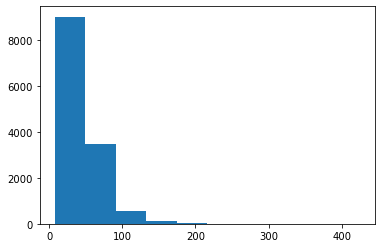

In [11]:
'''plt.hist(vec_len)'''

In [16]:
max_len

1331

In [18]:
max_len = 300
train_p1_seq = pad_sequences(train_p1_seq, maxlen=max_len, padding='post')
train_p2_seq = pad_sequences(train_p2_seq, maxlen=max_len, padding='post')
val_p1_seq = pad_sequences(val_p1_seq, maxlen=max_len, padding='post')
val_p2_seq = pad_sequences(val_p2_seq, maxlen=max_len, padding='post')

In [14]:
'''train_p1_seq.shape[1]'''

NameError: name 'train_p1_seq' is not defined

In [17]:
dir(training_generator)

['_DataGeneratorSiamese__get_data',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 'batch_size',
 'df',
 'index',
 'indices',
 'max_len',
 'num_classes',
 'on_epoch_end',
 'shuffle',
 'tokenizer']

In [13]:
x_gen,y_gen = training_generator.__getitem__(0)

In [28]:
history = model.fit([train_p1_seq,train_p2_seq],y_train.values.reshape(-1,1), validation_data=([val_p1_seq, val_p2_seq],y_val.values.reshape(-1,1)), verbose=1, batch_size=64, 
                             epochs=30, steps_per_epoch=100) #, callbacks=[callback]

Epoch 1/30
100/100 [==============================] - 30s 290ms/step - loss: 0.6955 - acc: 0.4920 - val_loss: 0.6893 - val_acc: 0.5355
Epoch 2/30
100/100 [==============================] - 29s 289ms/step - loss: 0.6875 - acc: 0.5396 - val_loss: 0.6880 - val_acc: 0.5413
Epoch 3/30
100/100 [==============================] - 29s 289ms/step - loss: 0.6878 - acc: 0.5343 - val_loss: 0.6875 - val_acc: 0.5443
Epoch 4/30
100/100 [==============================] - 29s 292ms/step - loss: 0.6876 - acc: 0.5479 - val_loss: 0.6873 - val_acc: 0.5443
Epoch 5/30
100/100 [==============================] - 29s 286ms/step - loss: 0.6849 - acc: 0.5534 - val_loss: 0.6872 - val_acc: 0.5464
Epoch 6/30
100/100 [==============================] - 28s 283ms/step - loss: 0.6866 - acc: 0.5404 - val_loss: 0.6869 - val_acc: 0.5477
Epoch 7/30
100/100 [==============================] - 28s 281ms/step - loss: 0.6802 - acc: 0.5695 - val_loss: 0.6868 - val_acc: 0.5478
Epoch 8/30
100/100 [==============================] - 2

In [31]:
[train_p1_seq[0:10],train_p2_seq[0:10]],y_train[0:10].values.reshape(-1,1)

([array([[   9,  188,   88, ...,    0,    0,    0],
         [  98,   11,   19, ...,    0,    0,    0],
         [   9,  146,  222, ...,    0,    0,    0],
         ...,
         [5886,    2,  343, ...,    0,    0,    0],
         [  12,  707,    9, ...,    0,    0,    0],
         [  15,   33,   16, ...,    0,    0,    0]], dtype=int32),
  array([[  98,   11,   19, ...,    0,    0,    0],
         [   9,  146,  222, ...,    0,    0,    0],
         [4321,   23,    4, ...,    0,    0,    0],
         ...,
         [  35,   69,   33, ...,    0,    0,    0],
         [  15,   33,   16, ...,    0,    0,    0],
         [ 129,  492,    4, ...,    0,    0,    0]], dtype=int32)],
 array([[1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]]))

In [14]:
x_gen, y_gen

([array([[   9,  188,   88, ...,    0,    0,    0],
         [  98,   11,   19, ...,    0,    0,    0],
         [   9,  146,  222, ...,    0,    0,    0],
         ...,
         [  77,    9, 1633, ...,    0,    0,    0],
         [  38,    1,   72, ...,    0,    0,    0],
         [  12,   20,  116, ...,    0,    0,    0]], dtype=int32),
  array([[  98,   11,   19, ...,    0,    0,    0],
         [   9,  146,  222, ...,    0,    0,    0],
         [4321,   23,    4, ...,    0,    0,    0],
         ...,
         [  38,    1,   72, ...,    0,    0,    0],
         [  12,   20,  116, ...,    0,    0,    0],
         [  12,  356,    3, ...,    0,    0,    0]], dtype=int32)],
 array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0]))

In [12]:
def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [39]:
def cosine_distance(vests):
    x, y = vests
    print(x.shape, y.shape)
    x =tf.keras.backend.l2_normalize(x, axis=-1)
    y = tf.keras.backend.l2_normalize(y, axis=-1)
    print("after normalization",x.shape, y.shape)
    tf.keras.backend.mean
    return -tf.keras.backend.mean(x * y, axis=-1, keepdims=True)

In [40]:
cosine_distance((tf.constant([1.,2.,3.]), tf.constant([1.,2.,3.])))

(3,) (3,)
after normalization (3,) (3,)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.33333328], dtype=float32)>

In [89]:
def manhattan_dist(vests):
    x, y = vests
    #lambda x: tf.keras.backend.abs(x[0] - x[1])
    return tf.keras.backend.mean(tf.keras.backend.abs(x - y), axis=-1, keepdims=True)

In [90]:
manhattan_dist((tf.constant([1.,2.,3.]), tf.constant([1.,2.,3.])))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [27]:
def euclidean_dist(vests):
    x, y = vests
# Euclidean distance between x1,x2
    l2diff = tf.math.sqrt(tf.reduce_sum(tf.math.square(tf.math.subtract(x, y))))
    #l2diff = tf.sqrt(tf.reduce_sum(tf.square(tf.sub(x, y)),reduction_indices=1))
    return l2diff

In [80]:
def euclidean_dist2(vests):
    x, y = vests
    #print(x.shape, y.shape, tf.keras.backend.l2_normalize(x-y, axis=-1))
    #return -tf.keras.backend.mean(tf.nn.l2_normalize(x-y, axis=-1), axis=-1, keepdims=True)
    return tf.keras.backend.mean(tf.keras.backend.l2_normalize(x-y, axis=-1), axis=-1, keepdims=True)

In [81]:
euclidean_dist2((tf.constant([1.,2.,3.]), tf.constant([1.,1.,3.])))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.33333334], dtype=float32)>

In [14]:
import tensorflow_addons as tfa

/home/sukanya/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [91]:

input_1 =  Input(shape=(max_len,))
input_2 =  Input(shape=(max_len,))

common_embed = Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embed_matrix], 
                       input_length=max_len,trainable=False) 
lstm_1 = common_embed(input_1)
lstm_2 = common_embed(input_2)


common_lstm = LSTM(64,return_sequences=True, activation="relu")
vector_1 = common_lstm(lstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_lstm(lstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(manhattan_dist, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)

model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

'''model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss(), metrics=['acc'])'''


"model.compile(\n    optimizer=tf.keras.optimizers.Adam(0.001),\n    loss=tfa.losses.TripletSemiHardLoss(), metrics=['acc'])"

In [92]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
synopsis_embedd (Embedding)     (None, 300, 50)      2795200     input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 300, 64)      29440       synopsis_embedd[0][0]      

In [79]:
history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=64, 
                             epochs=30, steps_per_epoch=100) #, callbacks=[callback]

Epoch 1/30
100/100 [==============================] - 25s 238ms/step - loss: 0.6928 - acc: 0.5219 - val_loss: 0.6896 - val_acc: 0.5376
Epoch 2/30
100/100 [==============================] - 24s 236ms/step - loss: 0.6883 - acc: 0.5402 - val_loss: 0.6907 - val_acc: 0.5368
Epoch 3/30
100/100 [==============================] - 24s 237ms/step - loss: 0.6924 - acc: 0.5270 - val_loss: 0.6898 - val_acc: 0.5376
Epoch 4/30
100/100 [==============================] - 24s 236ms/step - loss: 0.6893 - acc: 0.5400 - val_loss: 0.6900 - val_acc: 0.5349
Epoch 5/30
100/100 [==============================] - 24s 238ms/step - loss: 0.6875 - acc: 0.5448 - val_loss: 0.6890 - val_acc: 0.5380
Epoch 6/30
100/100 [==============================] - 24s 238ms/step - loss: 0.6860 - acc: 0.5587 - val_loss: 0.6888 - val_acc: 0.5375
Epoch 7/30
100/100 [==============================] - 23s 236ms/step - loss: 0.6853 - acc: 0.5485 - val_loss: 0.6890 - val_acc: 0.5385
Epoch 8/30
100/100 [==============================] - 2